In [1]:
%matplotlib inline
#from typing import Dict, Tuple, List, Union, Iterable

import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#from matplotlib.ticker import AutoMinorLocator
plt.style.use("lm")
import numpy as np
#import scipy.linalg as sl #expm
#import os
#import time
#import random
#import string
#import copy
#from tabulate import tabulate
import samplebase as sb

import path_utils as putils

In [2]:
from decimal import Decimal

def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

def to_latex_value_with_err(value, err, n_round=1, include_math_env=False):
    assert abs(value) > abs(err)
    val_exp = fexp(value)
    err_2 = err / (10**val_exp)
    n_round = max(-1*fexp(err_2),n_round)
    err_man = round(err_2, n_round)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    err_str = ("{:0." + str(n_round) + "f}").format(err_man)
    if val_exp==0:
        result = val_str + " \pm " + err_str
    else:
        result = r"( " + val_str + " \pm " + err_str + r")\times 10^" + "{" + str(val_exp) +"}"
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

def to_latex_value(value, n_round=1, include_math_env=False):
    val_exp = fexp(value)
    val_man = round(fman(value), n_round)
    val_str = ("{:0." + str(n_round) + "f}").format(val_man)
    if val_exp==0:
        result = val_str
    else:
        result = val_str + r"\times 10^" + "{" + str(val_exp) +"} "
    
    if include_math_env:
        result = r"$ " + result + r" $"
    return result

print(to_latex_value_with_err(1e-3, 0.5e-6))
print(to_latex_value(4e-3))
print(to_latex_value_with_err(1e-3, 0.5e-6, include_math_env=True))
print(to_latex_value(4e-3, include_math_env=True))
print(to_latex_value(1.3))
print(to_latex_value_with_err(1.2, 1.1))

( 1.0000 \pm 0.0005)\times 10^{-3}
4.0\times 10^{-3} 
$ ( 1.0000 \pm 0.0005)\times 10^{-3} $
$ 4.0\times 10^{-3}  $
1.3
1.2 \pm 1.1


In [3]:
def cluster_along_arg(samples, arg_key, arg_values):
    """
    Transform list of samples into a dictionary that maps 
    from arg_value (described by arg_key) to the clustered 
    samples list.
    """
    clustered_samples = dict()
    for arg_value in arg_values:
        clustered_samples[arg_value] = []
    
    for sample in samples:
        for arg_value in arg_values:
            if sample.args[arg_key] == arg_value:
                clustered_samples[arg_value].append(sample)
    
    return clustered_samples

In [4]:
def plot_overview(plot_functions, n_rows=1, n_cols=3, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.6*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        #secondrow = (idx in [7,8,9,10,11,12]) or (idx in [19,20,21,22,23,24]) or (idx in [31,32,33,34,35,36])
        #if secondrow:
        #    plt.gca().set_axis_bgcolor('#ededed')
        pf()
        idx += 1

    plt.subplots_adjust(top=0.96, bottom=0.04, left=0.07, right=0.97, hspace=0.4, wspace=0.35)
    #plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

In [5]:
data_dir = putils.data_dir(24)
data_dir

'/srv/public/chrisfr/workspace/data/rlearn-24'

In [6]:
all_samples = sb.list_of_samples(data_dir)
n_done = sum([1 for s in all_samples if s.done])
n_total = len(all_samples)
print(n_done, "/", n_total)

700 / 700


In [7]:
done_samples = [s for s in all_samples if s.done]

In [8]:
done_samples[0].args

{'alpha': array([1.67683294e-07, 2.22299648e-07, 2.94705170e-07, 3.90693994e-07,
        5.17947468e-07, 6.86648845e-07, 9.10298178e-07, 1.20679264e-06,
        1.59985872e-06, 2.12095089e-06]),
 'n_splits': 10,
 'gillespie_realisations': 20000,
 'iid_id': 5,
 'traj_file_path': './gillespie_trajs_init_1_shuffled.h5'}

In [9]:
done_samples[0].result["cv_result"][0]

{'alpha': 1.67683293681101e-07,
 'cutoff': 0.0,
 'l1_ratio': 1.0,
 'score': [-0.00015749719364643652,
  -0.00019821994189329426,
  -0.0001869570333552891,
  -0.00018426390115056565,
  -0.0001775657154704499,
  -0.000415964808361993,
  -0.00025356260182181545,
  -0.00016463252033959016,
  -0.00018525523169663548,
  -0.00019149544006837188]}

In [10]:
# get cv_result for every alpha, gill_real, iid
cv_results = []
# each data row (cv for one alpha, gill_real, id) has the form
example_element = {"alpha": 1e-6, "gillespie_realisations": 100, "iid": 0, "scores": [1.,2.,3.,4.,5.]}
for ds in done_samples:
    for alpha_idx, current_alpha in enumerate(ds.args["alpha"]):
        element = {
            "alpha": current_alpha, 
            "gillespie_realisations": ds.args["gillespie_realisations"], 
            "iid": ds.args["iid_id"], 
            "scores": np.array(ds.result["cv_result"][alpha_idx]["score"])}
        cv_results.append(element)

In [11]:
import pandas as pd

In [12]:
cv_results = pd.DataFrame(cv_results)

In [13]:
alphas = set()
timesteps = set()
noises = set()
folds = set()
iids = set()
gillespie_realisations = set()
for s in all_samples:
    if s.done:
        #alphas.add(s.args["alpha"])
        #timesteps.add(s.args["dt"])
        #noises.add(s.args["noise"])
        folds.add(s.args["n_splits"])
        gillespie_realisations.add(s.args["gillespie_realisations"])
        iids.add(s.args["iid_id"])
#alphas = np.fromiter(alphas, dtype=float)
#alphas.sort()
alphas = np.logspace(-8, -2, num=50)
timesteps = np.fromiter(timesteps, dtype=float)
timesteps.sort()
noises = np.fromiter(noises, dtype=float)
noises.sort()
folds = np.fromiter(folds, dtype=int)
folds.sort()
gillespie_realisations = np.fromiter(gillespie_realisations, dtype=int)
gillespie_realisations.sort()
iids = np.fromiter(iids, dtype=int)
iids.sort()
print(alphas)
print(timesteps)
print(noises)
print(folds)
print(gillespie_realisations)
print(iids)

[1.00000000e-08 1.32571137e-08 1.75751062e-08 2.32995181e-08
 3.08884360e-08 4.09491506e-08 5.42867544e-08 7.19685673e-08
 9.54095476e-08 1.26485522e-07 1.67683294e-07 2.22299648e-07
 2.94705170e-07 3.90693994e-07 5.17947468e-07 6.86648845e-07
 9.10298178e-07 1.20679264e-06 1.59985872e-06 2.12095089e-06
 2.81176870e-06 3.72759372e-06 4.94171336e-06 6.55128557e-06
 8.68511374e-06 1.15139540e-05 1.52641797e-05 2.02358965e-05
 2.68269580e-05 3.55648031e-05 4.71486636e-05 6.25055193e-05
 8.28642773e-05 1.09854114e-04 1.45634848e-04 1.93069773e-04
 2.55954792e-04 3.39322177e-04 4.49843267e-04 5.96362332e-04
 7.90604321e-04 1.04811313e-03 1.38949549e-03 1.84206997e-03
 2.44205309e-03 3.23745754e-03 4.29193426e-03 5.68986603e-03
 7.54312006e-03 1.00000000e-02]
[]
[]
[10]
[    1     2     5    10    20    50   100   200   500  1000  2000  5000
 10000 20000]
[0 1 2 3 4 5 6 7 8 9]


In [14]:
if False:
    samples = cluster_along_arg(done_samples, "gillespie_realisations", gillespie_realisations)
    for g in gillespie_realisations:
        samples[g] = cluster_along_arg(samples[g], "n_splits", folds)

In [15]:
def plot_validation(sample_list, mean=True, exclude_first_fold=True):
    #sorted_samples = sorted(sample_list, key=lambda x: x.args["alpha"])
    alpha_lower = 1e-9
    alpha_upper = 1e-2
    #sorted_samples = [s for s in sorted_samples if alpha_lower < s.args["alpha"] < alpha_upper ]
    #scores = np.array([ np.array(s.result["cv_result"][0]["score"]) for s in sorted_samples])
    #print(scores)
    alphas = []
    scores = []
    for s in sample_list:
        for result in s.result["cv_result"]:
            alphas.append(result["alpha"])
            scores.append(result["score"])
    alphas = np.array(alphas)
    scores = np.array(scores)
    n_samples = len(scores[0])
    #scores = np.mean(scores, axis=1)
    min_indices = np.argmin(-scores)
    #alphas = np.array([ s.args["alpha"] for s in sorted_samples])
    if mean:
        if exclude_first_fold:
            exclude_first = scores[:, 1:]
            mean_scores = np.mean(exclude_first, axis=1)
            err_scores = np.std(exclude_first, axis=1) / np.sqrt(n_samples-1 if n_samples>2 else 1)
        else:
            mean_scores = np.mean(scores, axis=1)
            err_scores = np.std(scores, axis=1) / np.sqrt(n_samples if n_samples>2 else 1)
        plt.errorbar(alphas, - mean_scores, yerr=err_scores, fmt=".")
        print("best mean score for alpha={}".format(alphas[np.argmin(-mean_scores)]))
    else:
        start_at = 1 if exclude_first_fold else 0
        for i in range(start_at, n_folds):
            #if i < 7:
            plt.plot(alphas, - scores[:,i], ".", label=str(i))
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")
    
def plot_trajs(sample_list, mean=True):
    sorted_samples = sorted(sample_list, key=lambda x: x.args["alpha"])
    traj_counts = [ s.result["counts"] for s in sorted_samples ]
    for counts in traj_counts[1:2]:
        plt.plot(counts, alpha=1.0)

In [16]:
n_folds=5
hyperparam_for_realisation = dict()

def plot_validation_pd(cv_results_for_g : pd.DataFrame, exclude_first_fold=False, mean=False, n_real=0):
    scores_for_alpha = []
    errs_for_alpha = []
    for a in alphas:
        slice_alpha = cv_results_for_g[cv_results_for_g.alpha == a]
        all_scores = np.array([x for x in slice_alpha.scores.values])
        #print(all_scores)
        if exclude_first_fold:
            scores = all_scores[:,1:]
        else:
            scores = all_scores
        
        if mean:
            # average over folds and iids
            n = scores.size
            mean_score = np.mean(scores)
            err_score = np.std(scores) / np.sqrt(n)
        else:
            # only average over iids
            n = scores.shape[0]
            mean_score = np.mean(scores, axis=0)
            err_score = np.std(scores, axis=0) / np.sqrt(n)
        
        scores_for_alpha.append(mean_score)
        errs_for_alpha.append(err_score)
    
    scores_for_alpha = np.array([x for x in scores_for_alpha])
    errs_for_alpha = np.array([x for x in errs_for_alpha])
    print(errs_for_alpha.shape)
    #if mean:
    min_indices = np.argmin(-scores_for_alpha, axis=0)
    #else:
    #    min_indices = 
    min_alpha = alphas[min_indices]
    print("n_real", n_real, "min_alpha", min_alpha)
    if mean:
        plt.errorbar(alphas, -scores_for_alpha, yerr=errs_for_alpha)
    else:
        for i in range(n_folds - 1 if exclude_first_fold else n_folds):
            plt.errorbar(alphas, -scores_for_alpha[:, i], yerr=errs_for_alpha[:,i],
                         label="fold "+str(i + 1 if exclude_first_fold else i))
    plt.legend()
    plt.title(r"$n_\mathrm{real}=" + str(n_real) + r"$, $\alpha_\mathrm{min}=$" + str(min_alpha if mean else ""))
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\alpha$")
    plt.ylabel("score")
    
    if mean:
        hyperparam_for_realisation[n_real] = min_alpha

In [17]:
pfs = []
for g in gillespie_realisations:
    cv_results_g = cv_results[cv_results.gillespie_realisations == g]
    #plot_validation_pd(cv_results_g, exclude_first_score=True, mean=True)
    pfs.append(lambda df=cv_results_g, _g=g: plot_validation_pd(df, mean=True, exclude_first_fold=False, n_real=_g))

[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.


(50,)
n_real 1 min_alpha 0.00010985411419875573
(50,)
n_real 2 min_alpha 0.00025595479226995333
(50,)
n_real 5 min_alpha 6.250551925273976e-05
(50,)
n_real 10 min_alpha 8.286427728546843e-05


[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.


(50,)
n_real 20 min_alpha 6.5512855685955095e-06
(50,)
n_real 50 min_alpha 1.5264179671752335e-05
(50,)
n_real 100 min_alpha 6.5512855685955095e-06
(50,)
n_real 200 min_alpha 2.1209508879201924e-06


[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.


(50,)
n_real 500 min_alpha 2.811768697974231e-06
(50,)
n_real 1000 min_alpha 5.179474679231213e-07
(50,)
n_real 2000 min_alpha 1.2067926406393288e-06
(50,)
n_real 5000 min_alpha 2.811768697974231e-06


[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.
[samplebase] [2018-09-24 10:44:52] [WARNING] No handles with labels found to put in legend.


(50,)
n_real 10000 min_alpha 1.67683293681101e-07
(50,)
n_real 20000 min_alpha 5.4286754393238595e-08


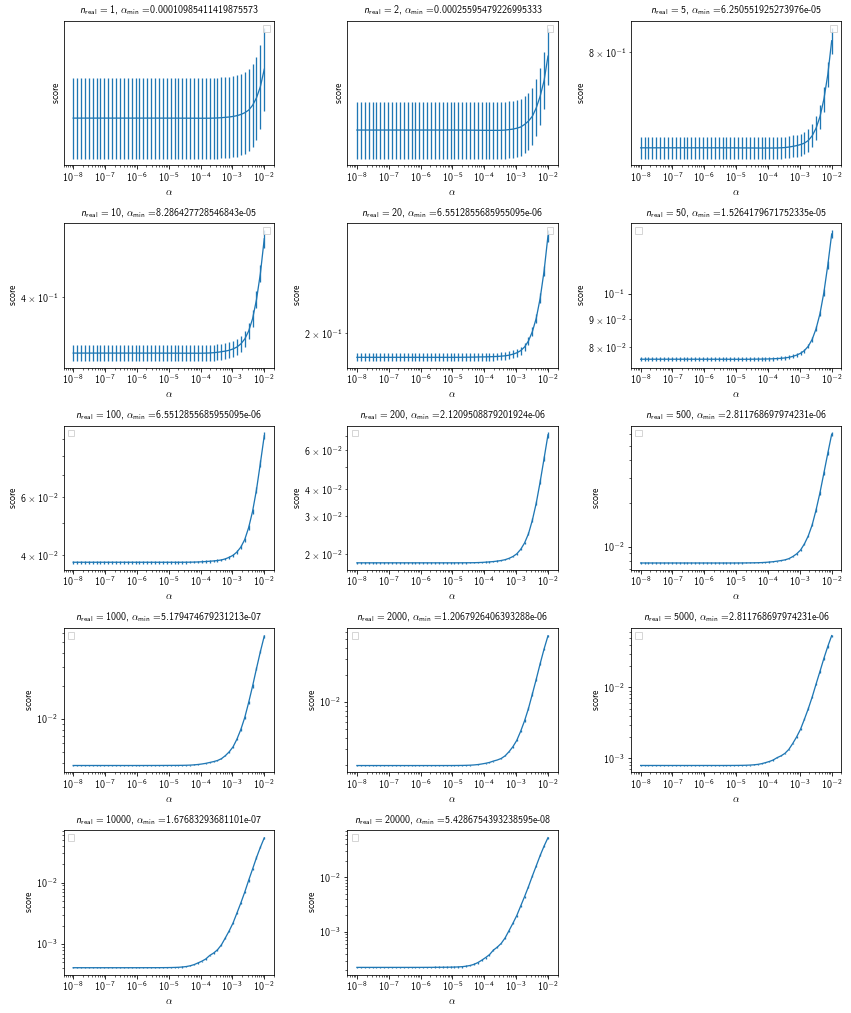

In [18]:
plot_overview(pfs, n_rows=5, n_cols=3, size_factor=0.8)
#plt.savefig("cv_gill_kfold_scale500_singlefolds_all_folds.pdf", bbox_inches="tight", transparent=True)

Text(0,0.5,'hyperparameter found by kfold')

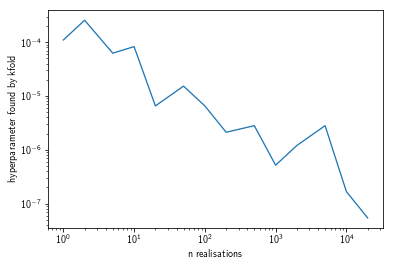

In [19]:
plt.plot([x for x in hyperparam_for_realisation.keys()], [x for x in hyperparam_for_realisation.values()])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n realisations")
plt.ylabel("hyperparameter found by kfold")

In [20]:
if False:
    import pickle
    with open("hyperparam.pickle", "wb") as f:
        pickle.dump(hyperparam_for_realisation, f)

In [21]:
if False:
    import pickle
    with open("hyperparam.pickle", "rb") as f:
        hyperparam_for_realisation = pickle.load(f)

## l1 vs n_real
For each $n_\mathrm{real}$ and $iid$ solve the system and compare the according estimated rates with the desired rates.

In [22]:
import run_cv as rs

In [23]:
dt = 3e-3
target_time = 2.
#use_n_folds = 5 # only use the last as test-set

In [24]:
# get desired rates
regulation_network, analysis = rs.get_regulation_network(dt, 0.0, target_time, gillespie_realisations=None, scale=1.)
desired_rates = regulation_network.desired_rates

obtaining regulation network with dt = 0.003
generating data by integrating the law of mass action with additive lma_noise 0.0
0.003
0.003


In [25]:
import time

(g,i)=(1,0) ...
find hyperparameter
current scores [3.60844441 3.60844439 3.60844437 3.60844436 3.60844433 3.6084443
 3.60844425 3.60844419 3.6084441  3.60844399 3.60844385 3.60844366
 3.6084434  3.60844306 3.60844261 3.60844202 3.60844123 3.60844018
 3.6084388  3.60843697 3.60843455 3.60843135 3.60842711 3.60842152
 3.60841415 3.60840445 3.60839171 3.60837506 3.60835267 3.60832229
 3.60829082 3.6082412  3.60814955 3.60803429 3.60792552 3.60779464
 3.60748075 3.60710434 3.60680055 3.60671    3.60724857 3.60791558
 3.60922872 3.61101699 3.61404718 3.61643559 3.61814948 3.62231474
 3.6311754  3.64526193]


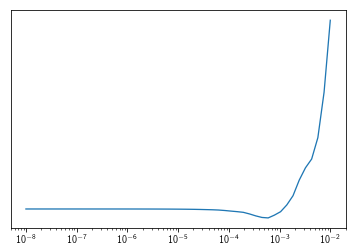

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0005963623316594637, lambda=1.0)!
status 0: Optimization terminated successfully.
211 / 30000 iterations
applying cutoff
... took 24.484264363069087 seconds
(g,i)=(1,1) ...
find hyperparameter
current scores [3.38923695 3.38923697 3.38923698 3.389237   3.38923703 3.38923707
 3.38923712 3.38923719 3.38923729 3.38923741 3.38923757 3.38923778
 3.38923806 3.38923843 3.38923893 3.38923958 3.38924045 3.38924161
 3.38924314 3.38924518 3.38924789 3.38925149 3.38925628 3.38926223
 3.38926845 3.3892768  3.38929585 3.38932372 3.38935423 3.38939462
 3.38944903 3.38952335 3.38960652 3.38973323 3.38984247 3.38997211
 3.3901523  3.39020756 3.39057943 3.39098545 3.39155819 3.39240818
 3.3923306  3.39170357 3.39119179 

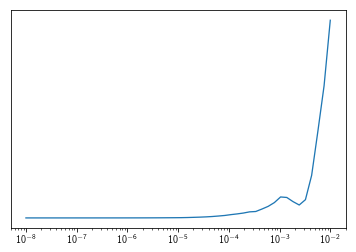

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
267 / 30000 iterations
applying cutoff
... took 30.173172291019 seconds
(g,i)=(1,2) ...
find hyperparameter
current scores [3.61286872 3.61286873 3.61286869 3.61286876 3.61286879 3.6128688
 3.61286886 3.61286892 3.612869   3.6128691  3.61286923 3.61286941
 3.61286964 3.61286995 3.61287034 3.61287091 3.61287182 3.61287305
 3.61287467 3.61287683 3.61287968 3.61288348 3.61288852 3.61289521
 3.6129038  3.61291454 3.6129292  3.61294979 3.61297692 3.6130236
 3.61310323 3.61321094 3.61332944 3.61349603 3.61367825 3.61393552
 3.614303   3.61483698 3.61580364 3.61728918 3.61878115 3.62029403
 3.62163556 3.62107558 3.62168319 3.62423977 3.62993563

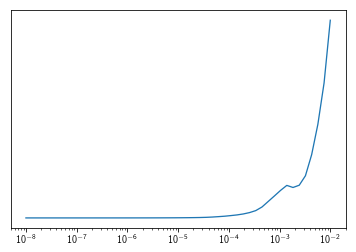

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.757510624854793e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
276 / 30000 iterations
applying cutoff
... took 32.48221423092764 seconds
(g,i)=(1,3) ...
find hyperparameter
current scores [3.43334861 3.43334859 3.43334858 3.43334856 3.43334853 3.43334849
 3.43334844 3.43334836 3.43334827 3.43334815 3.43334799 3.43334778
 3.4333475  3.43334712 3.43334663 3.43334597 3.4333451  3.43334394
 3.43334241 3.43334038 3.4333377  3.43333414 3.43332943 3.43332313
 3.43331459 3.43330331 3.43328842 3.4332688  3.43323997 3.43319878
 3.43314142 3.43306456 3.43296477 3.43283503 3.43270111 3.43256667
 3.43242151 3.43237055 3.43232011 3.43225132 3.43216121 3.43259859
 3.43360556 3.43457652 3.43548524 3

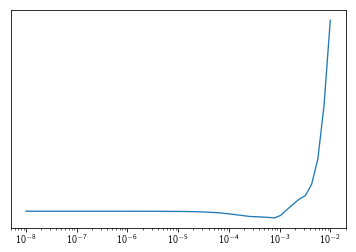

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0007906043210907702, lambda=1.0)!
status 0: Optimization terminated successfully.
217 / 30000 iterations
applying cutoff
... took 25.441614700946957 seconds
(g,i)=(1,4) ...
find hyperparameter
current scores [3.76983345 3.76983346 3.76983348 3.76983351 3.76983354 3.76983358
 3.76983363 3.76983371 3.76983381 3.76983393 3.7698341  3.76983433
 3.76983463 3.76983503 3.76983556 3.76983626 3.76983719 3.76983843
 3.76984007 3.76984225 3.76984514 3.769849   3.76985411 3.76986097
 3.76987011 3.76988216 3.76989829 3.76992012 3.7699497  3.76999012
 3.7700519  3.77013905 3.77023325 3.77026515 3.7703324  3.77038253
 3.77057755 3.77098385 3.77157621 3.77182655 3.77164475 3.77268931
 3.77377185 3.77721862 3.78079899 

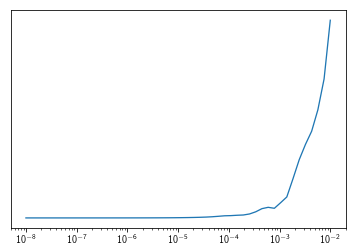

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
215 / 30000 iterations
applying cutoff
... took 25.373000732040964 seconds
(g,i)=(1,5) ...
find hyperparameter
current scores [3.57367942 3.57367942 3.57367942 3.57367941 3.5736794  3.57367939
 3.57367938 3.57367937 3.57367935 3.57367932 3.57367929 3.57367924
 3.57367917 3.57367909 3.57367898 3.57367883 3.57367864 3.57367838
 3.57367805 3.5736776  3.57367702 3.57367626 3.57367528 3.57367404
 3.57367249 3.57366928 3.57366255 3.57365269 3.5736437  3.57363671
 3.57363266 3.57363788 3.5736613  3.57372225 3.57388333 3.57412551
 3.57451521 3.57501667 3.57544451 3.57593511 3.57610271 3.57620361
 3.5767894  3.57932283 3.58182463 3.5840005  3.588

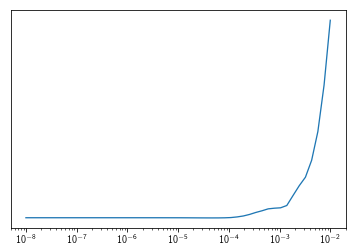

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.71486636345739e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
224 / 30000 iterations
applying cutoff
... took 25.35808574501425 seconds
(g,i)=(1,6) ...
find hyperparameter
current scores [3.70605362 3.70605361 3.70605357 3.70605351 3.70605345 3.70605336
 3.70605324 3.70605308 3.70605287 3.70605259 3.70605223 3.70605174
 3.70605109 3.70605024 3.7060491  3.7060476  3.7060456  3.70604296
 3.70603946 3.70603482 3.70602868 3.70602054 3.70600979 3.70599557
 3.70597678 3.70595174 3.70591829 3.70587428 3.70581654 3.7057447
 3.70568062 3.70562713 3.70559622 3.70556932 3.70562286 3.70575144
 3.70605116 3.70654771 3.70693899 3.707606   3.70783971 3.70769173
 3.70767408 3.70776787 3.70860886 3.7

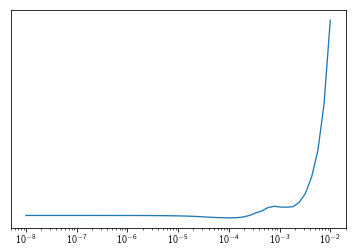

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
248 / 30000 iterations
applying cutoff
... took 29.104799686931074 seconds
(g,i)=(1,7) ...
find hyperparameter
current scores [3.83411542 3.83411541 3.8341154  3.83411538 3.83411537 3.83411535
 3.83411532 3.83411528 3.83411523 3.83411516 3.83411506 3.83411494
 3.83411478 3.83411455 3.83411427 3.83411389 3.83411338 3.83411271
 3.83411182 3.83411064 3.83410908 3.83410701 3.83410426 3.83410063
 3.83409582 3.83408946 3.83408215 3.83407383 3.83406286 3.83404841
 3.83402937 3.83400459 3.8339722  3.83393021 3.83386608 3.83378343
 3.83370757 3.83363435 3.83359367 3.83356323 3.83356243 3.8341455
 3.8352898  3.83638521 3.83805582 

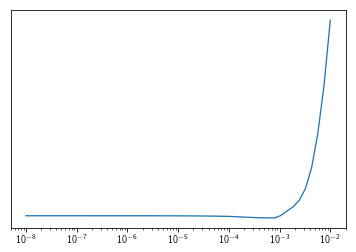

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0007906043210907702, lambda=1.0)!
status 0: Optimization terminated successfully.
174 / 30000 iterations
applying cutoff
... took 20.676888454938307 seconds
(g,i)=(1,8) ...
find hyperparameter
current scores [3.58898113 3.58898111 3.58898107 3.58898103 3.58898096 3.58898088
 3.58898077 3.58898063 3.58898044 3.58898019 3.58897985 3.58897941
 3.58897882 3.58897805 3.58897701 3.58897565 3.58897384 3.58897144
 3.58896825 3.58896404 3.58895847 3.5889511  3.58894163 3.58892921
 3.58891283 3.58889125 3.58886193 3.5888229  3.58877347 3.58870944
 3.58862607 3.58850934 3.58834455 3.58815966 3.58790631 3.58754747
 3.58736778 3.58730962 3.58742351 3.58772522 3.58804262 3.58772857
 3.58745238 3.58757009 3.58792753 

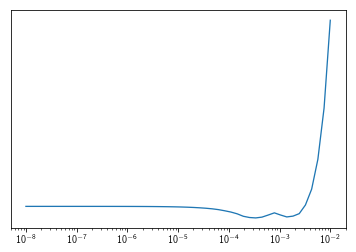

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.000339322177189533, lambda=1.0)!
status 0: Optimization terminated successfully.
219 / 30000 iterations
applying cutoff
... took 25.833010592963547 seconds
(g,i)=(1,9) ...
find hyperparameter
current scores [3.71241571 3.7124157  3.71241568 3.71241567 3.71241564 3.7124156
 3.71241556 3.7124155  3.71241542 3.71241532 3.71241518 3.712415
 3.71241476 3.71241444 3.71241401 3.71241345 3.7124127  3.71241171
 3.7124104  3.71240868 3.71240637 3.71240334 3.71239933 3.71239404
 3.71238708 3.71237793 3.71236594 3.71235361 3.71234087 3.71232601
 3.7123075  3.7122839  3.71225559 3.71225116 3.71227781 3.71235383
 3.71235428 3.71217115 3.71172759 3.711163   3.71082865 3.71069848
 3.71090974 3.71147764 3.71246862 3.71

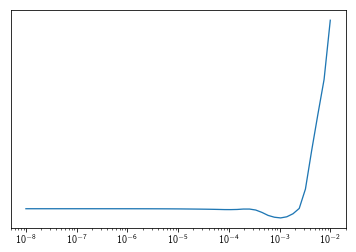

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0010481131341546852, lambda=1.0)!
status 0: Optimization terminated successfully.
194 / 30000 iterations
applying cutoff
... took 24.066360278986394 seconds
(g,i)=(2,0) ...
find hyperparameter
current scores [2.01221021 2.01221021 2.01221021 2.0122102  2.0122102  2.01221019
 2.01221018 2.01221018 2.01221016 2.01221015 2.01221013 2.0122101
 2.01221006 2.01221001 2.01220994 2.01220986 2.01220974 2.01220959
 2.01220939 2.01220913 2.01220879 2.01220834 2.01220777 2.01220704
 2.01220611 2.01220375 2.01220013 2.01219592 2.01218815 2.01217406
 2.01216025 2.01214598 2.0121276  2.01211597 2.01209133 2.0121102
 2.01218187 2.01258704 2.01320945 2.01419671 2.01520754 2.01586328
 2.01593893 2.01588461 2.01619519 2.

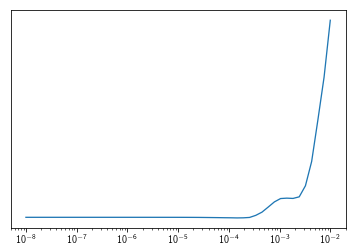

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00014563484775012445, lambda=1.0)!
status 0: Optimization terminated successfully.
253 / 30000 iterations
applying cutoff
... took 28.74547999294009 seconds
(g,i)=(2,1) ...
find hyperparameter
current scores [1.80742113 1.80742111 1.80742109 1.80742107 1.80742103 1.80742098
 1.80742092 1.80742084 1.80742073 1.80742058 1.80742039 1.80742014
 1.8074198  1.80741935 1.80741876 1.80741797 1.80741693 1.80741555
 1.80741372 1.8074113  1.8074081  1.80740386 1.80739816 1.80738984
 1.80737881 1.80736284 1.80733955 1.80730871 1.80726695 1.8072096
 1.8071313  1.80701777 1.80687435 1.80670358 1.80663686 1.80639195
 1.80614379 1.80591275 1.80563791 1.80540707 1.805241   1.80542744
 1.80597863 1.80716134 1.80912697 1

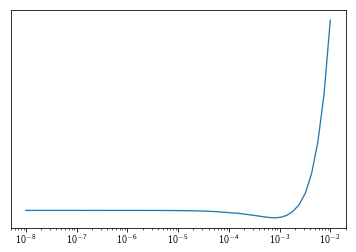

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0007906043210907702, lambda=1.0)!
status 0: Optimization terminated successfully.
208 / 30000 iterations
applying cutoff
... took 24.40754623292014 seconds
(g,i)=(2,2) ...
find hyperparameter
current scores [1.81959468 1.8195947  1.81959472 1.81959476 1.8195948  1.81959486
 1.81959493 1.81959504 1.81959517 1.81959535 1.81959559 1.8195959
 1.81959632 1.81959687 1.81959761 1.81959858 1.81959987 1.81960158
 1.81960385 1.81960687 1.81961087 1.81961618 1.81962324 1.81963263
 1.81964513 1.81965771 1.81967243 1.81969139 1.81971739 1.81974606
 1.81979031 1.81987596 1.81997897 1.82011179 1.82032255 1.82055065
 1.82082337 1.82119559 1.82172297 1.82282852 1.82370326 1.82450747
 1.82570513 1.8290484  1.83301841 1.

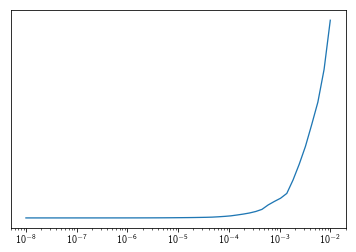

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
251 / 30000 iterations
applying cutoff
... took 28.90556739200838 seconds
(g,i)=(2,3) ...
find hyperparameter
current scores [1.87366976 1.87366976 1.87366976 1.87366977 1.87366977 1.87366978
 1.87366979 1.87366981 1.87366983 1.87366986 1.87366988 1.87366993
 1.87366999 1.87367007 1.87367017 1.87367031 1.8736705  1.87367075
 1.87367108 1.87367152 1.87367211 1.87367291 1.87367377 1.87367434
 1.87367531 1.87367741 1.87368211 1.87369021 1.87370185 1.87371898
 1.87374124 1.87376598 1.87378843 1.87378036 1.87368986 1.87353251
 1.87327642 1.87289684 1.87273632 1.87269789 1.87284442 1.87333284
 1.8744314  1.87813057 1.88058124 1.88180959 1.8847

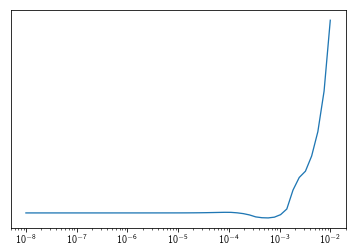

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0005963623316594637, lambda=1.0)!
status 0: Optimization terminated successfully.
218 / 30000 iterations
applying cutoff
... took 25.9614595429739 seconds
(g,i)=(2,4) ...
find hyperparameter
current scores [1.82452438 1.82452439 1.82452439 1.8245244  1.82452441 1.82452443
 1.82452444 1.82452447 1.8245245  1.82452454 1.8245246  1.82452468
 1.82452478 1.82452491 1.82452509 1.82452532 1.82452563 1.82452605
 1.8245266  1.82452744 1.82452832 1.82452964 1.82453142 1.82453372
 1.82453678 1.82453981 1.82454228 1.824542   1.82454077 1.82454046
 1.82453329 1.82451154 1.82449826 1.82450469 1.82455782 1.82463778
 1.82475172 1.82480027 1.82488119 1.82523844 1.82557381 1.82640344
 1.82758768 1.82786866 1.82941114 1.

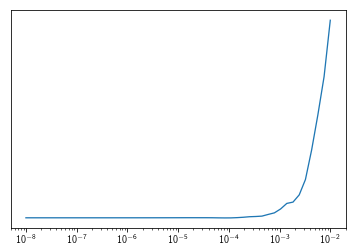

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.286427728546843e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
262 / 30000 iterations
applying cutoff
... took 31.44294906500727 seconds
(g,i)=(2,5) ...
find hyperparameter
current scores [1.86461629 1.86461626 1.86461623 1.86461617 1.86461611 1.86461602
 1.86461591 1.86461576 1.86461556 1.86461534 1.86461495 1.86461449
 1.86461388 1.86461307 1.864612   1.86461057 1.86460871 1.8646062
 1.86460289 1.86459851 1.86459271 1.86458503 1.86457404 1.86455883
 1.86454109 1.86451901 1.86448993 1.86445293 1.8644037  1.86434141
 1.86428669 1.86422075 1.86414299 1.86405399 1.86397228 1.8639835
 1.86402155 1.86419216 1.86471969 1.86520228 1.86504339 1.86562078
 1.86608372 1.8673205  1.86921172 1.8

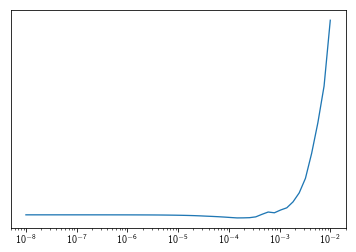

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00014563484775012445, lambda=1.0)!
status 0: Optimization terminated successfully.
268 / 30000 iterations
applying cutoff
... took 31.63242000795435 seconds
(g,i)=(2,6) ...
find hyperparameter
current scores [1.71258095 1.71258094 1.71258092 1.7125809  1.71258088 1.71258085
 1.7125808  1.71258075 1.71258067 1.71258057 1.71258044 1.71258027
 1.71258004 1.71257974 1.71257933 1.7125788  1.71257809 1.71257715
 1.71257591 1.71257427 1.7125721  1.71256925 1.71256549 1.71256057
 1.71255412 1.71254572 1.71253512 1.71252835 1.71252201 1.71250551
 1.71248198 1.71244154 1.71242154 1.71244646 1.71251029 1.71259604
 1.71268692 1.7127899  1.7129017  1.71271349 1.71284103 1.71337472
 1.71398519 1.71542455 1.7185188  

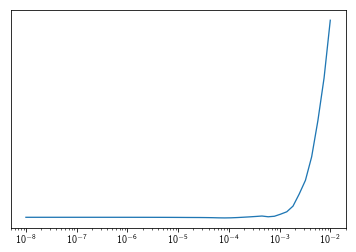

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.286427728546843e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
271 / 30000 iterations
applying cutoff
... took 32.375117999035865 seconds
(g,i)=(2,7) ...
find hyperparameter
current scores [1.86942717 1.86942717 1.86942717 1.86942717 1.86942724 1.86942718
 1.86942718 1.86942718 1.86942718 1.86942718 1.86942718 1.86942718
 1.86942719 1.8694272  1.8694272  1.86942721 1.86942722 1.86942724
 1.86942726 1.8694273  1.86942736 1.86942744 1.86942756 1.86942777
 1.86942806 1.86942872 1.8694273  1.86942228 1.86941612 1.8694088
 1.86939296 1.86937197 1.86933135 1.86926556 1.86920093 1.86912116
 1.86904484 1.86908095 1.86910371 1.86896633 1.86889398 1.86903999
 1.8693392  1.87041161 1.87262114 1

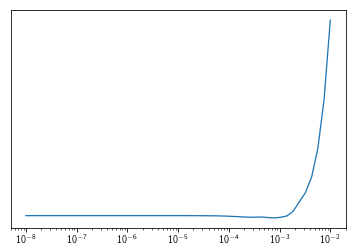

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0007906043210907702, lambda=1.0)!
status 0: Optimization terminated successfully.
220 / 30000 iterations
applying cutoff
... took 25.732279966934584 seconds
(g,i)=(2,8) ...
find hyperparameter
current scores [1.77247018 1.77247017 1.77247016 1.77247015 1.77247014 1.77247011
 1.77247008 1.77247004 1.77246999 1.77246992 1.77246984 1.77246972
 1.77246956 1.77246936 1.77246908 1.77246872 1.77246824 1.77246761
 1.77246678 1.77246568 1.77246422 1.77246231 1.77245981 1.77245654
 1.77245215 1.7724447  1.77243462 1.77242169 1.77240959 1.77238862
 1.7723533  1.7723092  1.77226538 1.77224575 1.77227615 1.7723918
 1.77256678 1.77264488 1.7725715  1.77277504 1.77299787 1.77336442
 1.77418235 1.77521736 1.77605986 1

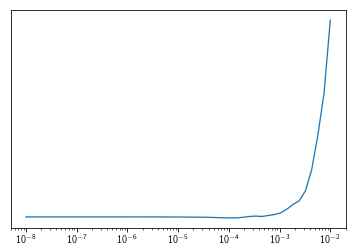

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
265 / 30000 iterations
applying cutoff
... took 31.287415281985886 seconds
(g,i)=(2,9) ...
find hyperparameter
current scores [1.90664111 1.9066411  1.90664108 1.90664107 1.90664104 1.90664101
 1.90664097 1.90664092 1.90664085 1.90664076 1.90664063 1.90664047
 1.90664025 1.90663996 1.90663958 1.90663907 1.9066384  1.90663751
 1.90663634 1.90663476 1.90663292 1.90663026 1.90662676 1.90662216
 1.90661611 1.90660629 1.90658497 1.90655314 1.90651114 1.90646306
 1.90641122 1.90634867 1.90627482 1.90620854 1.90610512 1.90598027
 1.9057514  1.9055327  1.9054071  1.90578945 1.90629045 1.90723449
 1.90816674 1.91060187 1.91262239

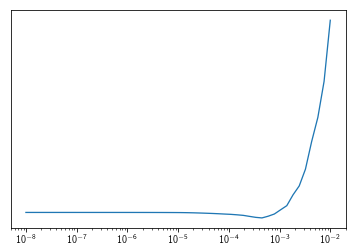

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0004498432668969444, lambda=1.0)!
status 0: Optimization terminated successfully.
248 / 30000 iterations
applying cutoff
... took 29.699380012927577 seconds
(g,i)=(5,0) ...
find hyperparameter
current scores [0.76351421 0.76351419 0.76351416 0.76351413 0.76351408 0.76351402
 0.76351394 0.76351383 0.76351369 0.76351349 0.76351324 0.7635129
 0.76351246 0.76351186 0.76351108 0.76351004 0.76350867 0.76350685
 0.76350445 0.76350127 0.76349707 0.76349107 0.76348435 0.76347615
 0.76346557 0.76345177 0.76343364 0.76341114 0.76338527 0.76334806
 0.76329401 0.76322262 0.76314525 0.76312101 0.76313131 0.76315389
 0.76331971 0.76346314 0.7637168  0.76412603 0.76465907 0.76539147
 0.76642013 0.76792225 0.77025486 0

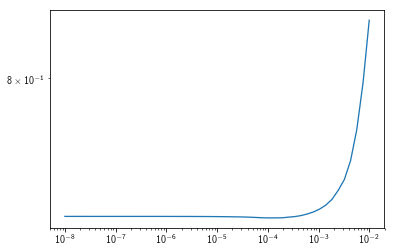

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
302 / 30000 iterations
applying cutoff
... took 35.928756654961035 seconds
(g,i)=(5,1) ...
find hyperparameter
current scores [0.73475149 0.73475147 0.73475144 0.73475139 0.73475134 0.73475127
 0.73475114 0.73475103 0.73475087 0.73475066 0.73475036 0.73474997
 0.73474945 0.73474876 0.73474782 0.73474658 0.73474493 0.73474275
 0.73473986 0.73473603 0.73473095 0.73472423 0.73471534 0.73470342
 0.73468878 0.73466982 0.73464611 0.73462093 0.73457528 0.73452035
 0.73446102 0.73438872 0.73430649 0.73424428 0.7342139  0.73420374
 0.73426199 0.73424399 0.73418592 0.73421493 0.73438237 0.73477859
 0.73555594 0.73710336 0.73987675

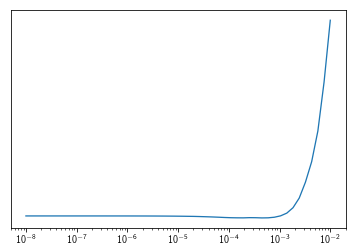

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0004498432668969444, lambda=1.0)!
status 0: Optimization terminated successfully.
270 / 30000 iterations
applying cutoff
... took 31.241130633978173 seconds
(g,i)=(5,2) ...
find hyperparameter
current scores [0.75118141 0.7511814  0.7511814  0.75118139 0.75118137 0.75118136
 0.75118133 0.7511813  0.75118126 0.7511812  0.75118113 0.75118103
 0.7511809  0.75118073 0.75118051 0.75118025 0.75117995 0.75117956
 0.75117905 0.7511784  0.7511775  0.75117637 0.75117496 0.75117285
 0.7511701  0.75116639 0.75115932 0.75115441 0.75113889 0.75112805
 0.75111602 0.7510939  0.75107324 0.75102145 0.75090806 0.75081965
 0.75067349 0.7505806  0.7506525  0.75109988 0.75147349 0.75183459
 0.75259238 0.75389961 0.75619834 

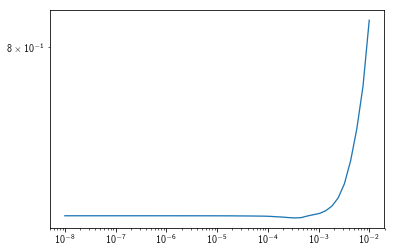

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.000339322177189533, lambda=1.0)!
status 0: Optimization terminated successfully.
255 / 30000 iterations
applying cutoff
... took 29.607472158037126 seconds
(g,i)=(5,3) ...
find hyperparameter
current scores [0.74851724 0.74851723 0.74851722 0.7485172  0.74851717 0.74851713
 0.74851708 0.74851702 0.74851693 0.74851682 0.74851667 0.74851647
 0.74851621 0.74851586 0.74851539 0.74851478 0.74851397 0.74851289
 0.74851147 0.74850959 0.7485071  0.74850359 0.74849885 0.74849255
 0.74848316 0.74847059 0.74845079 0.74842401 0.74838844 0.74835977
 0.74832278 0.74828297 0.74826869 0.74829757 0.74840295 0.74857277
 0.74880556 0.7490517  0.74932627 0.74944874 0.7495918  0.74999344
 0.75079555 0.75266171 0.75578613 0

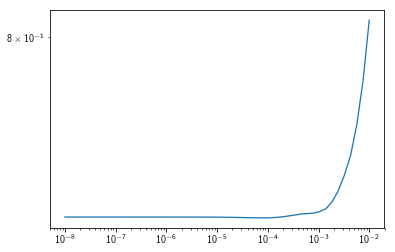

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.286427728546843e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
292 / 30000 iterations
applying cutoff
... took 32.59826221794356 seconds
(g,i)=(5,4) ...
find hyperparameter
current scores [0.74881926 0.74881925 0.74881923 0.74881921 0.74881918 0.74881914
 0.74881909 0.74881903 0.74881894 0.74881883 0.74881867 0.74881847
 0.7488182  0.74881783 0.74881735 0.74881671 0.74881586 0.74881473
 0.74881325 0.7488113  0.74880889 0.74880571 0.74880151 0.74879598
 0.74878871 0.7487799  0.74877242 0.74876891 0.74876604 0.74876279
 0.74876    0.74875871 0.74876545 0.74879081 0.74883135 0.74893732
 0.74915608 0.74936881 0.74993419 0.75077248 0.75126015 0.75192187
 0.75292366 0.75448057 0.75739911 0

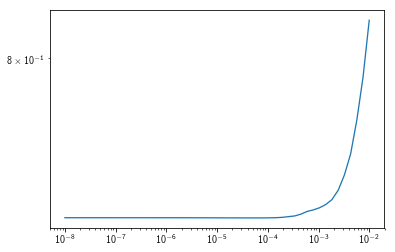

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.250551925273976e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
276 / 30000 iterations
applying cutoff
... took 30.850914200069383 seconds
(g,i)=(5,5) ...
find hyperparameter
current scores [0.76132313 0.76132314 0.76132314 0.76132315 0.76132316 0.76132317
 0.76132319 0.76132322 0.76132325 0.76132329 0.76132335 0.76132343
 0.76132353 0.76132366 0.76132383 0.76132406 0.76132437 0.76132477
 0.76132531 0.76132602 0.76132698 0.76132827 0.76133004 0.76133245
 0.76133567 0.76134147 0.76135151 0.76136464 0.76137611 0.76139076
 0.76141845 0.7614618  0.76153607 0.76165598 0.76183795 0.76202787
 0.76212274 0.76204163 0.7621894  0.76241996 0.7627181  0.7632333
 0.7641559  0.76595621 0.76883456 0

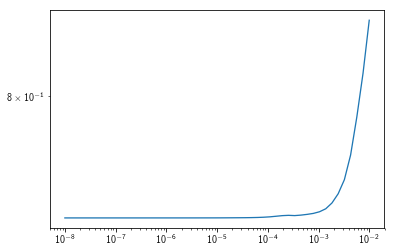

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
297 / 30000 iterations
applying cutoff
... took 34.0792324449867 seconds
(g,i)=(5,6) ...
find hyperparameter
current scores [0.73782779 0.73782778 0.73782775 0.73782772 0.73782768 0.73782762
 0.73782754 0.73782744 0.73782731 0.73782713 0.7378269  0.73782659
 0.73782618 0.73782563 0.73782491 0.73782395 0.73782268 0.737821
 0.73781877 0.73781582 0.73781192 0.73780675 0.73780007 0.7377908
 0.73777813 0.73776318 0.73774532 0.73772434 0.73770623 0.73769444
 0.73769351 0.73770115 0.73771571 0.73772892 0.73772637 0.73774452
 0.73782167 0.73800609 0.73830786 0.73881967 0.73988019 0.74140997
 0.74210192 0.74261186 0.7437503  0.74607863 0.75034547

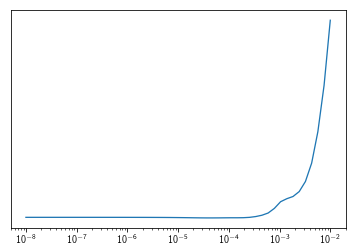

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.71486636345739e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
301 / 30000 iterations
applying cutoff
... took 34.50751904200297 seconds
(g,i)=(5,7) ...
find hyperparameter
current scores [0.77366476 0.77366474 0.77366471 0.77366467 0.77366462 0.77366456
 0.77366447 0.77366435 0.7736642  0.77366399 0.77366372 0.77366336
 0.77366289 0.77366226 0.7736616  0.77366079 0.77365976 0.77365839
 0.77365657 0.77365464 0.77365276 0.77365029 0.77364683 0.77364178
 0.77363382 0.77362841 0.77362288 0.7736199  0.77361402 0.77361572
 0.77360875 0.77359694 0.77360401 0.77361286 0.77353288 0.77345767
 0.77352457 0.77357974 0.77381391 0.77385281 0.77406787 0.77438529
 0.775058   0.7763993  0.77895817 0.

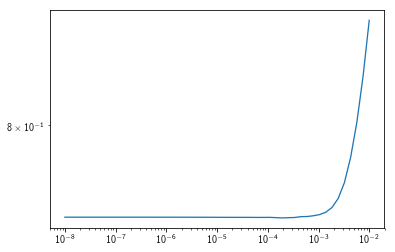

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00019306977288832496, lambda=1.0)!
status 0: Optimization terminated successfully.
292 / 30000 iterations
applying cutoff
... took 33.66420328198001 seconds
(g,i)=(5,8) ...
find hyperparameter
current scores [0.72966668 0.72966667 0.72966665 0.72966663 0.72966661 0.72966657
 0.72966653 0.72966647 0.72966639 0.72966629 0.72966615 0.72966596
 0.72966572 0.7296654  0.72966497 0.72966441 0.72966366 0.72966248
 0.72966084 0.72965868 0.72965584 0.72965208 0.72964721 0.7296411
 0.72963381 0.72962259 0.7296074  0.72958645 0.72955928 0.72952377
 0.7294969  0.72946351 0.72947964 0.72954848 0.72961878 0.72972206
 0.72986456 0.7301431  0.73052679 0.7308068  0.73095525 0.73108287
 0.73128796 0.73221874 0.73412578 0

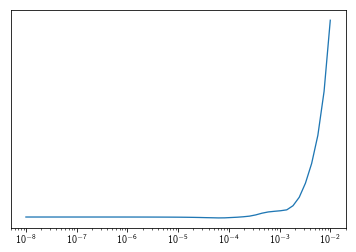

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.250551925273976e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
302 / 30000 iterations
applying cutoff
... took 34.65097694506403 seconds
(g,i)=(5,9) ...
find hyperparameter
current scores [0.76733248 0.76733248 0.76733249 0.76733249 0.7673325  0.76733251
 0.76733253 0.76733254 0.76733257 0.7673326  0.76733265 0.7673327
 0.76733278 0.76733289 0.76733302 0.76733321 0.76733345 0.76733378
 0.76733421 0.76733433 0.7673345  0.76733475 0.76733514 0.76733805
 0.76734516 0.76735855 0.76737678 0.76740177 0.76743738 0.76748751
 0.76755845 0.76763613 0.76771458 0.76765697 0.76751392 0.76723396
 0.767242   0.76738769 0.76759541 0.76797691 0.76835057 0.7684268
 0.76865186 0.76920361 0.7704417  0.7

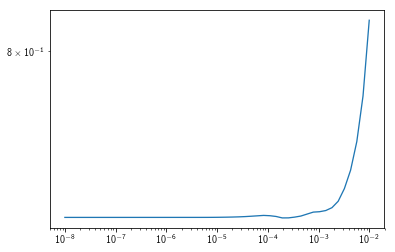

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00019306977288832496, lambda=1.0)!
status 0: Optimization terminated successfully.
272 / 30000 iterations
applying cutoff
... took 30.797786362003535 seconds
(g,i)=(10,0) ...
find hyperparameter
current scores [0.36809042 0.36809038 0.36809035 0.36809032 0.36809028 0.36809021
 0.36809014 0.36809003 0.36808989 0.36808971 0.36808947 0.36808915
 0.36808872 0.36808816 0.36808742 0.36808643 0.36808513 0.36808342
 0.36808116 0.36807805 0.36807384 0.36806806 0.36805975 0.3680488
 0.36803458 0.36801563 0.3679871  0.36794759 0.36789737 0.36785113
 0.3678116  0.36775997 0.36774698 0.36776782 0.36781474 0.36789224
 0.36802194 0.36831934 0.36879323 0.36894858 0.36930606 0.36978635
 0.37045083 0.37171482 0.37400555

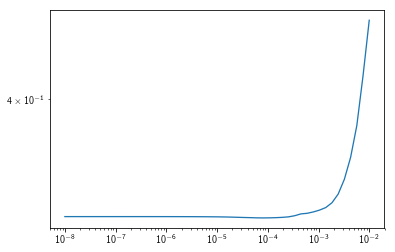

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.286427728546843e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
314 / 30000 iterations
applying cutoff
... took 36.029470073990524 seconds
(g,i)=(10,1) ...
find hyperparameter
current scores [0.38659053 0.38659053 0.38659052 0.38659052 0.38659052 0.38659052
 0.38659051 0.3865905  0.3865905  0.38659049 0.38659047 0.38659045
 0.38659043 0.38659039 0.38659035 0.38659032 0.38659036 0.38659043
 0.38659051 0.38659064 0.38659081 0.38659105 0.38659141 0.38659193
 0.38659272 0.38659394 0.38659634 0.38660073 0.38660822 0.38661702
 0.38662822 0.38661374 0.38657579 0.3865187  0.38652447 0.38666078
 0.3868149  0.387039   0.38714103 0.387435   0.38813506 0.38970401
 0.39085254 0.39218117 0.3942244 

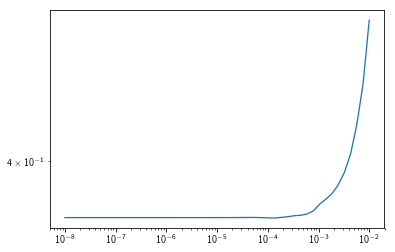

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
284 / 30000 iterations
applying cutoff
... took 34.502582786022685 seconds
(g,i)=(10,2) ...
find hyperparameter
current scores [0.36362013 0.36362016 0.36362019 0.36362024 0.36362027 0.36362034
 0.36362044 0.36362056 0.36362073 0.36362095 0.36362124 0.36362163
 0.36362215 0.36362283 0.36362374 0.36362498 0.36362715 0.36363002
 0.3636338  0.36363881 0.36364543 0.36365579 0.36366968 0.36368885
 0.36372031 0.36376478 0.36381708 0.36388537 0.36397037 0.36402972
 0.36405841 0.36412224 0.3641409  0.36412244 0.36412293 0.36408723
 0.36400861 0.36389695 0.3639477  0.36403312 0.36422182 0.36457557
 0.36521158 0.36631724 0.3682355

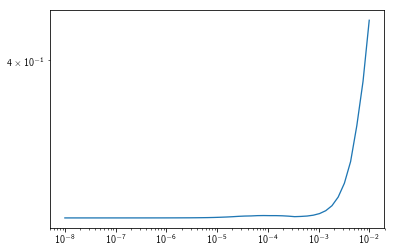

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
327 / 30000 iterations
applying cutoff
... took 36.284522322937846 seconds
(g,i)=(10,3) ...
find hyperparameter
current scores [0.37360955 0.37360955 0.37360954 0.37360953 0.37360952 0.3736095
 0.37360947 0.37360944 0.3736094  0.37360935 0.37360927 0.37360918
 0.37360905 0.37360888 0.37360865 0.37360836 0.37360797 0.37360753
 0.37360703 0.37360647 0.37360579 0.37360499 0.3736046  0.37360402
 0.37360183 0.37359973 0.37359871 0.37359502 0.37358943 0.3735827
 0.37357799 0.37358455 0.37363116 0.37376217 0.37407214 0.37438488
 0.37467071 0.37480629 0.37487529 0.3749715  0.37515519 0.37552609
 0.37628706 0.37732786 0.37894041 0.38177284 0.3865

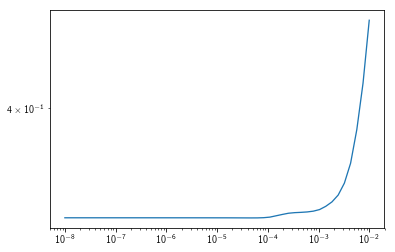

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.71486636345739e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
334 / 30000 iterations
applying cutoff
... took 38.18889044295065 seconds
(g,i)=(10,4) ...
find hyperparameter
current scores [0.37534328 0.37534327 0.37534322 0.37534318 0.37534311 0.37534303
 0.37534292 0.37534278 0.37534259 0.37534233 0.37534199 0.37534155
 0.37534096 0.37534018 0.37533913 0.37533775 0.37533591 0.37533345
 0.37533018 0.37532582 0.37532008 0.37531223 0.37530178 0.37529004
 0.37527423 0.37525308 0.37522692 0.37519464 0.37517497 0.37518
 0.37517516 0.37518425 0.37524423 0.37528844 0.37529332 0.37526533
 0.37528201 0.37535674 0.37554177 0.37569728 0.37595237 0.37639653
 0.37693016 0.37796245 0.37965359 0.38

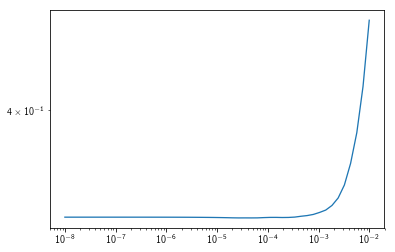

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
334 / 30000 iterations
applying cutoff
... took 37.97413774393499 seconds
(g,i)=(10,5) ...
find hyperparameter
current scores [0.38623841 0.38623841 0.3862384  0.38623839 0.38623838 0.38623836
 0.38623834 0.38623832 0.38623828 0.38623823 0.38623816 0.38623808
 0.38623796 0.38623781 0.38623761 0.38623735 0.38623701 0.38623656
 0.38623598 0.38623522 0.38623425 0.38623291 0.38623095 0.38622851
 0.38622566 0.38622266 0.38622049 0.38622572 0.38623359 0.38624822
 0.38627043 0.38629941 0.38634504 0.3864237  0.38636442 0.38637091
 0.38652862 0.3868443  0.38723498 0.38774599 0.38814825 0.38861657
 0.3894433  0.39092498 0.39308567

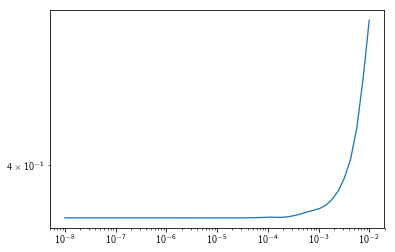

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
320 / 30000 iterations
applying cutoff
... took 36.713464142987505 seconds
(g,i)=(10,6) ...
find hyperparameter
current scores [0.38144085 0.38144084 0.38144082 0.3814408  0.38144077 0.38144073
 0.38144068 0.38144061 0.38144051 0.38144039 0.38144023 0.38144001
 0.38143972 0.38143934 0.38143884 0.38143817 0.38143729 0.38143613
 0.38143459 0.38143256 0.38142979 0.38142589 0.38141983 0.38141094
 0.38139727 0.38138092 0.38135961 0.38133045 0.38129382 0.38125281
 0.38121669 0.38117887 0.38113386 0.38108465 0.38105529 0.3811396
 0.3812313  0.38133724 0.38182032 0.3821718  0.38255714 0.38293992
 0.38375178 0.38522743 0.38740266

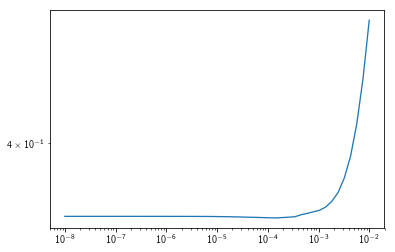

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00014563484775012445, lambda=1.0)!
status 0: Optimization terminated successfully.
291 / 30000 iterations
applying cutoff
... took 33.5463450680254 seconds
(g,i)=(10,7) ...
find hyperparameter
current scores [0.38287992 0.38287991 0.38287989 0.38287986 0.38287983 0.38287978
 0.38287972 0.38287964 0.38287953 0.38287938 0.38287919 0.38287893
 0.3828786  0.38287815 0.38287755 0.38287676 0.38287572 0.38287433
 0.38287254 0.38287027 0.38286729 0.38286334 0.3828586  0.38285336
 0.38284589 0.38283849 0.38283188 0.38282355 0.38280481 0.3827831
 0.38276295 0.38275474 0.38277233 0.38277689 0.38268333 0.3825643
 0.38259771 0.38267178 0.38276253 0.38299358 0.38341953 0.38416052
 0.3852917  0.38665629 0.38879489 0.

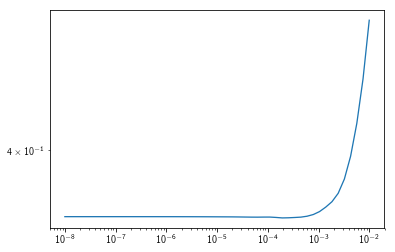

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00019306977288832496, lambda=1.0)!
status 0: Optimization terminated successfully.
317 / 30000 iterations
applying cutoff
... took 35.30383268604055 seconds
(g,i)=(10,8) ...
find hyperparameter
current scores [0.38939772 0.38939769 0.38939765 0.3893976  0.38939753 0.38939744
 0.38939733 0.38939717 0.38939696 0.38939668 0.38939632 0.38939583
 0.38939519 0.38939434 0.38939321 0.38939172 0.38938975 0.38938715
 0.38938372 0.38937921 0.38937328 0.38936523 0.38935501 0.38934192
 0.38932693 0.38930905 0.38928661 0.38927566 0.38924861 0.38926203
 0.38929137 0.38926697 0.38923004 0.38921438 0.38933933 0.38949642
 0.38974024 0.39014618 0.39035309 0.39054845 0.39068501 0.39092366
 0.39164773 0.3929748  0.39536943

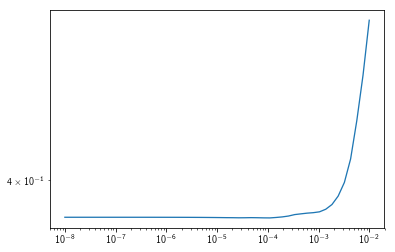

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
299 / 30000 iterations
applying cutoff
... took 33.64403395098634 seconds
(g,i)=(10,9) ...
find hyperparameter
current scores [0.35177309 0.35177309 0.35177309 0.35177309 0.35177308 0.35177308
 0.35177307 0.35177307 0.35177306 0.35177304 0.35177303 0.351773
 0.35177297 0.35177293 0.35177288 0.35177281 0.35177273 0.35177262
 0.35177245 0.35177192 0.35177099 0.35176974 0.35176783 0.3517654
 0.35176101 0.35175535 0.3517484  0.3517352  0.35171977 0.35173398
 0.35175821 0.35173057 0.35160959 0.35155889 0.35157745 0.3516436
 0.35172991 0.35192854 0.35223194 0.35263862 0.3531285  0.35369132
 0.3546449  0.35630751 0.35863626 0.3

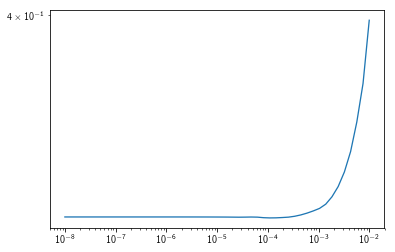

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
304 / 30000 iterations
applying cutoff
... took 35.682069202070124 seconds
(g,i)=(20,0) ...
find hyperparameter
current scores [0.1958918  0.19589179 0.19589178 0.19589177 0.19589175 0.19589173
 0.1958917  0.19589167 0.19589162 0.19589156 0.19589147 0.19589136
 0.19589121 0.19589101 0.19589076 0.19589041 0.19588996 0.1958893
 0.1958883  0.195887   0.19588526 0.19588291 0.19588009 0.19587715
 0.19587423 0.19587137 0.19586788 0.19586323 0.19585884 0.1958677
 0.19590036 0.19595643 0.19603765 0.19607563 0.19606036 0.1960973
 0.19614848 0.19624004 0.19640411 0.19665471 0.1969874  0.19755332
 0.19836186 0.1996041  0.20145561 0

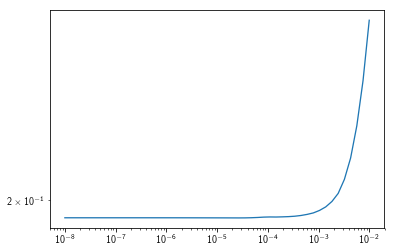

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
348 / 30000 iterations
applying cutoff
... took 40.540721377008595 seconds
(g,i)=(20,1) ...
find hyperparameter
current scores [0.1913177  0.1913177  0.19131769 0.19131768 0.19131766 0.19131764
 0.19131761 0.19131757 0.19131752 0.19131745 0.19131736 0.19131725
 0.19131709 0.19131671 0.19131609 0.19131527 0.19131419 0.19131276
 0.19131087 0.19130837 0.19130506 0.19130049 0.19129443 0.19128645
 0.19127601 0.19126342 0.19123766 0.19120589 0.19117373 0.19115338
 0.19118138 0.19125897 0.19133526 0.19145912 0.19150336 0.19152407
 0.19161522 0.19171553 0.19187812 0.19214095 0.1924922  0.19294927
 0.19371236 0.19506822 0.1973803

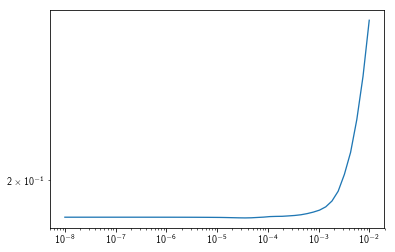

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.5564803062231284e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
329 / 30000 iterations
applying cutoff
... took 36.44151353801135 seconds
(g,i)=(20,2) ...
find hyperparameter
current scores [0.19427244 0.19427244 0.19427242 0.19427241 0.19427239 0.19427236
 0.19427233 0.19427228 0.19427221 0.19427213 0.19427202 0.19427187
 0.19427168 0.19427142 0.19427108 0.19427061 0.19427007 0.19426953
 0.19426883 0.19426794 0.19426679 0.19426533 0.19426351 0.19426132
 0.19425877 0.19426268 0.19427759 0.19430616 0.19434366 0.19437383
 0.19436526 0.19433596 0.19431449 0.19432024 0.19436584 0.19444443
 0.19451721 0.19468013 0.19491925 0.19516969 0.19558442 0.19614187
 0.19694293 0.19831894 0.20067942

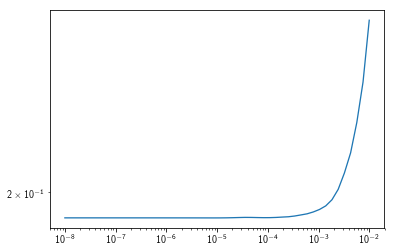

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
349 / 30000 iterations
applying cutoff
... took 38.903209854033776 seconds
(g,i)=(20,3) ...
find hyperparameter
current scores [0.19400915 0.19400916 0.19400916 0.19400916 0.19400916 0.19400917
 0.19400918 0.19400919 0.1940092  0.19400921 0.19400924 0.19400927
 0.1940093  0.19400936 0.19400943 0.19400952 0.19400964 0.1940098
 0.19400986 0.19400995 0.19401007 0.19401034 0.19401243 0.19401545
 0.19402195 0.19403228 0.19405052 0.19407854 0.19411636 0.19413289
 0.19411153 0.19407344 0.19403984 0.19403521 0.19406843 0.19412426
 0.1941781  0.19427182 0.19442793 0.19469521 0.19513608 0.19565789
 0.19651637 0.19785378 0.20019126 0

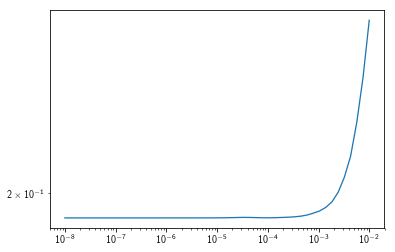

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
347 / 30000 iterations
applying cutoff
... took 39.697574058081955 seconds
(g,i)=(20,4) ...
find hyperparameter
current scores [0.19743451 0.1974345  0.1974345  0.19743449 0.19743447 0.19743445
 0.19743443 0.19743439 0.19743435 0.19743429 0.19743422 0.19743412
 0.19743398 0.19743381 0.19743358 0.19743327 0.19743288 0.19743244
 0.19743187 0.19743113 0.19742999 0.19742912 0.19742824 0.19742742
 0.19742661 0.19742548 0.19742711 0.19743636 0.19743911 0.19744052
 0.1974101  0.19739861 0.1973819  0.19737288 0.19739201 0.19755486
 0.19772186 0.19779431 0.19787985 0.19804877 0.19834188 0.19892236
 0.19997656 0.20176322 0.20441346 0.20840951 0.21

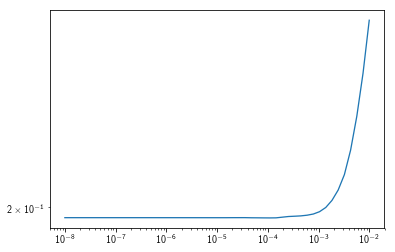

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.00010985411419875573, lambda=1.0)!
status 0: Optimization terminated successfully.
308 / 30000 iterations
applying cutoff
... took 35.47082765796222 seconds
(g,i)=(20,5) ...
find hyperparameter
current scores [0.18539341 0.18539342 0.18539344 0.18539346 0.18539348 0.18539351
 0.18539356 0.18539362 0.18539369 0.18539379 0.18539393 0.1853941
 0.18539434 0.18539462 0.18539498 0.18539545 0.18539606 0.18539697
 0.18539837 0.18540023 0.1854027  0.18540587 0.18540987 0.18541447
 0.18542197 0.18543383 0.18545079 0.1854745  0.1855071  0.18556724
 0.18566096 0.18577922 0.1859375  0.18605765 0.18618433 0.18627841
 0.18636696 0.18638134 0.18647931 0.18670764 0.18704018 0.18739728
 0.18808696 0.18935316 0.19156441 

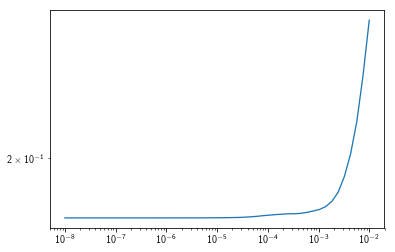

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
366 / 30000 iterations
applying cutoff
... took 40.35781378799584 seconds
(g,i)=(20,6) ...
find hyperparameter
current scores [0.18507671 0.18507674 0.18507672 0.18507673 0.18507673 0.18507674
 0.18507675 0.18507677 0.18507679 0.18507683 0.18507686 0.18507691
 0.18507698 0.18507707 0.18507719 0.18507735 0.18507757 0.18507786
 0.18507827 0.18507884 0.18507995 0.18508171 0.18508441 0.18508825
 0.18509584 0.18510982 0.18513759 0.18518289 0.18524015 0.1852702
 0.18527834 0.18528921 0.18522958 0.18514411 0.18510787 0.1851273
 0.18512811 0.18532158 0.18551053 0.18595317 0.18668515 0.18726631
 0.18779686 0.18886293 0.19089962 0.19396075 0.19939

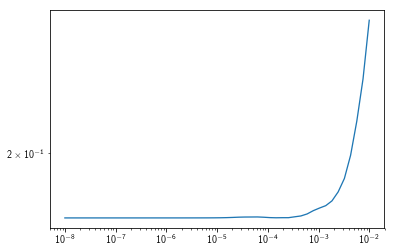

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
367 / 30000 iterations
applying cutoff
... took 40.67697267001495 seconds
(g,i)=(20,7) ...
find hyperparameter
current scores [0.18326747 0.18326747 0.18326747 0.18326747 0.18326747 0.18326747
 0.18326748 0.18326749 0.18326749 0.1832675  0.18326752 0.18326754
 0.18326756 0.1832676  0.18326765 0.18326772 0.18326782 0.18326797
 0.18326819 0.18326858 0.18326892 0.18327038 0.1832726  0.18327529
 0.18327453 0.18327548 0.18328121 0.18328808 0.18329881 0.18328526
 0.18327115 0.18332532 0.18338662 0.18341434 0.18349794 0.18365136
 0.18374778 0.18379001 0.18385692 0.18397255 0.18421374 0.18476962
 0.18574984 0.18748905 0.18999177 0.1936916  0.199

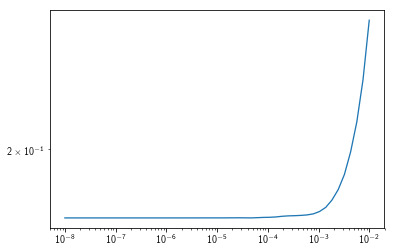

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.757510624854793e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
362 / 30000 iterations
applying cutoff
... took 41.403221265994944 seconds
(g,i)=(20,8) ...
find hyperparameter
current scores [0.18319375 0.18319373 0.1831937  0.18319366 0.18319361 0.18319353
 0.18319344 0.18319332 0.18319315 0.18319293 0.18319265 0.18319226
 0.18319176 0.18319109 0.1831902  0.18318904 0.18318766 0.18318564
 0.18318309 0.18318023 0.18317777 0.18317415 0.1831691  0.18316314
 0.18315658 0.18315929 0.1831556  0.18314327 0.1831249  0.18311588
 0.18313457 0.18317844 0.1832354  0.18328059 0.18333111 0.18330017
 0.1833246  0.18341157 0.183518   0.18369074 0.18400592 0.18454903
 0.18549353 0.18687104 0.18920311

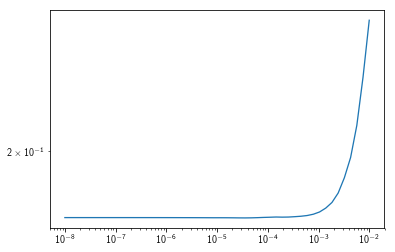

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.5564803062231284e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
323 / 30000 iterations
applying cutoff
... took 37.06776899495162 seconds
(g,i)=(20,9) ...
find hyperparameter
current scores [0.19573537 0.19573538 0.19573539 0.19573541 0.19573544 0.19573547
 0.19573552 0.19573557 0.19573565 0.19573576 0.1957359  0.19573608
 0.19573632 0.19573666 0.1957371  0.19573768 0.19573844 0.19573929
 0.19574043 0.19574197 0.19574416 0.19574711 0.19575139 0.19575684
 0.19576376 0.19576889 0.19578009 0.19580981 0.19584948 0.19591591
 0.19600511 0.19613221 0.19619311 0.19614895 0.19614887 0.19617295
 0.19622883 0.1962824  0.19637857 0.19660415 0.19689794 0.19740593
 0.19831753 0.19994939 0.20265076

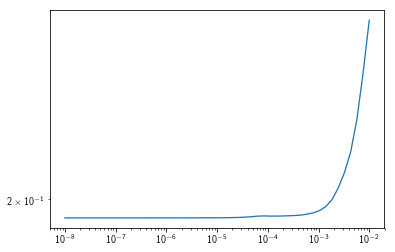

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
349 / 30000 iterations
applying cutoff
... took 38.97423070296645 seconds
(g,i)=(50,0) ...
find hyperparameter
current scores [0.07629339 0.07629339 0.07629338 0.07629336 0.07629335 0.07629333
 0.0762933  0.07629326 0.07629321 0.07629318 0.07629314 0.07629308
 0.07629299 0.07629289 0.07629276 0.07629259 0.07629225 0.07629153
 0.07629054 0.07628902 0.0762867  0.07628337 0.0762789  0.07627205
 0.07626709 0.07626446 0.07626508 0.07627235 0.07629391 0.07632043
 0.07634461 0.07635913 0.07636059 0.0763486  0.07635727 0.07639521
 0.07645203 0.07655506 0.07671692 0.07698523 0.07739784 0.07794691
 0.07890608 0.08034504 0.0826949  0.08591627 0.090

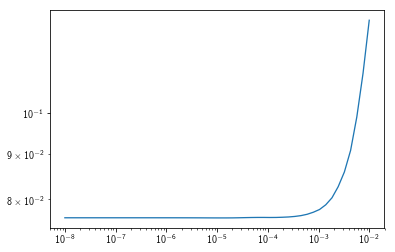

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.1513953993264481e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
358 / 30000 iterations
applying cutoff
... took 42.43912502902094 seconds
(g,i)=(50,1) ...
find hyperparameter
current scores [0.07878889 0.07878889 0.07878888 0.07878888 0.07878887 0.07878886
 0.07878885 0.07878883 0.07878881 0.07878878 0.07878874 0.0787887
 0.07878866 0.0787886  0.07878854 0.07878843 0.07878831 0.07878808
 0.07878782 0.07878752 0.07878731 0.07878697 0.07878626 0.07878507
 0.0787823  0.0787797  0.07877898 0.07882094 0.07887558 0.07889585
 0.07890192 0.07887832 0.07885879 0.07885819 0.0788786  0.07896715
 0.07910183 0.07921343 0.07939017 0.07975433 0.080275   0.0809103
 0.08193056 0.08371253 0.08623896 0

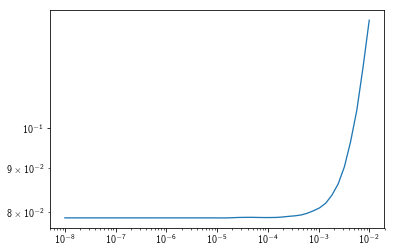

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
364 / 30000 iterations
applying cutoff
... took 41.460727046011016 seconds
(g,i)=(50,2) ...
find hyperparameter
current scores [0.07547449 0.07547448 0.07547448 0.07547447 0.07547446 0.07547445
 0.07547444 0.07547442 0.0754744  0.07547436 0.07547432 0.07547426
 0.07547419 0.07547409 0.07547393 0.07547369 0.07547336 0.0754728
 0.07547218 0.07547133 0.07547093 0.07546985 0.07547019 0.07547092
 0.07546955 0.07546366 0.0754525  0.07544385 0.07543642 0.0754328
 0.07543904 0.07546011 0.07550997 0.07558306 0.07565335 0.07570522
 0.07577702 0.07586703 0.07601338 0.07629377 0.07665245 0.07722279
 0.07797063 0.079282   0.08156178 

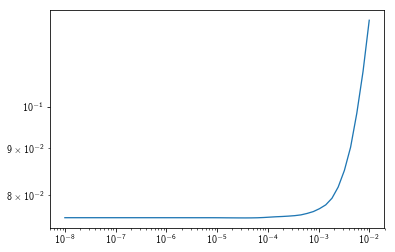

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.5564803062231284e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
359 / 30000 iterations
applying cutoff
... took 40.58919569500722 seconds
(g,i)=(50,3) ...
find hyperparameter
current scores [0.07497216 0.07497216 0.07497215 0.07497214 0.07497214 0.07497213
 0.07497212 0.07497209 0.07497206 0.07497204 0.07497199 0.07497193
 0.07497186 0.07497175 0.0749716  0.0749714  0.07497119 0.07497121
 0.07497119 0.07497075 0.07496925 0.07496779 0.07496676 0.0749652
 0.07496367 0.07496264 0.07496709 0.07497483 0.07496999 0.07496489
 0.07497804 0.07500326 0.07505635 0.07510225 0.07511905 0.07514264
 0.07519365 0.07528963 0.07544713 0.07571886 0.0761967  0.07690398
 0.07790977 0.07964043 0.08229464 

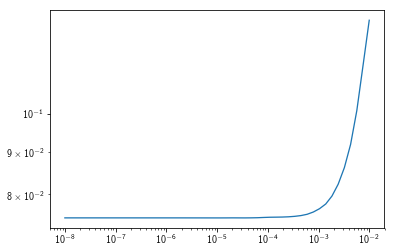

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.1513953993264481e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
363 / 30000 iterations
applying cutoff
... took 40.57329525495879 seconds
(g,i)=(50,4) ...
find hyperparameter
current scores [0.07533674 0.07533672 0.07533671 0.07533668 0.07533667 0.07533663
 0.07533658 0.07533652 0.07533644 0.07533634 0.0753362  0.07533602
 0.07533574 0.07533529 0.07533482 0.07533427 0.07533319 0.07533147
 0.07532916 0.0753261  0.07532243 0.07531575 0.07530704 0.07530041
 0.07529527 0.07528943 0.07528403 0.07529257 0.0753161  0.07534806
 0.07536467 0.07538708 0.07541745 0.07547627 0.07551992 0.07554144
 0.07560175 0.0756936  0.07585566 0.07607174 0.0764305  0.07704962
 0.07805041 0.07948915 0.08186908

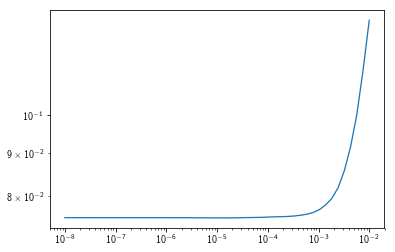

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
380 / 30000 iterations
applying cutoff
... took 43.65130655292887 seconds
(g,i)=(50,5) ...
find hyperparameter
current scores [0.07553508 0.07553507 0.07553504 0.075535   0.07553495 0.07553489
 0.07553482 0.07553472 0.07553455 0.07553438 0.07553402 0.07553362
 0.07553304 0.07553229 0.0755313  0.07552995 0.07552816 0.07552591
 0.07552307 0.0755198  0.07551809 0.07551802 0.07551741 0.07551625
 0.07551236 0.07550195 0.07549947 0.07550446 0.07551116 0.0755113
 0.07550878 0.07550676 0.07551654 0.07554574 0.07559666 0.07563148
 0.07566046 0.07575343 0.07592067 0.07620971 0.0767071  0.07735867
 0.07833233 0.07983017 0.08204958 

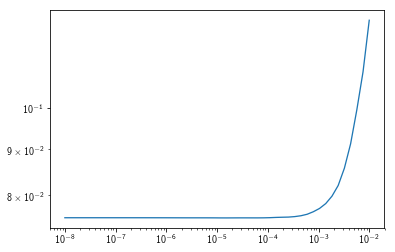

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
379 / 30000 iterations
applying cutoff
... took 43.1997584879864 seconds
(g,i)=(50,6) ...
find hyperparameter
current scores [0.07851231 0.07851232 0.0785123  0.07851229 0.07851228 0.07851227
 0.07851225 0.07851222 0.07851219 0.07851215 0.07851209 0.07851202
 0.07851192 0.0785118  0.07851164 0.07851143 0.07851118 0.07851088
 0.07851052 0.07851043 0.07850916 0.07850608 0.07850059 0.07849312
 0.07848697 0.07848028 0.07847568 0.07847025 0.07847258 0.07848589
 0.07849492 0.07850319 0.07851269 0.07855276 0.07863869 0.07876772
 0.07887006 0.0789636  0.07910201 0.07932848 0.07962077 0.08005564
 0.08075542 0.0820045  0.08419891 

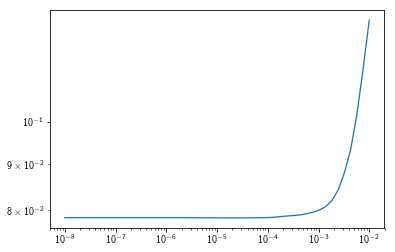

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
376 / 30000 iterations
applying cutoff
... took 42.58050150494091 seconds
(g,i)=(50,7) ...
find hyperparameter
current scores [0.07794224 0.07794225 0.07794225 0.07794227 0.07794229 0.07794232
 0.07794236 0.07794241 0.07794247 0.07794255 0.07794267 0.07794281
 0.07794301 0.07794327 0.07794364 0.07794436 0.07794533 0.07794661
 0.07794834 0.07795069 0.07795385 0.07795818 0.07796359 0.0779709
 0.0779818  0.07799387 0.07800725 0.07801311 0.07803729 0.07810082
 0.07816675 0.07818659 0.0782482  0.07829606 0.07835788 0.0785144
 0.07861584 0.07881014 0.07917766 0.07965106 0.08010157 0.08066917
 0.08142941 0.08275641 0.0850725  0

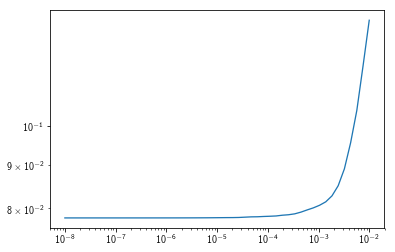

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
349 / 30000 iterations
applying cutoff
... took 40.88075934094377 seconds
(g,i)=(50,8) ...
find hyperparameter
current scores [0.07299044 0.07299041 0.07299038 0.07299034 0.07299028 0.07299021
 0.07299011 0.07298999 0.07298982 0.07298959 0.07298929 0.0729889
 0.07298837 0.07298768 0.07298676 0.07298555 0.07298396 0.07298198
 0.07297945 0.0729763  0.07297242 0.07296775 0.07296265 0.07295751
 0.07295342 0.0729507  0.07294813 0.07294726 0.07294812 0.07296532
 0.07299413 0.07301415 0.07305271 0.07310898 0.07316152 0.07324949
 0.07335042 0.07357792 0.07391109 0.07417395 0.07453606 0.07510989
 0.07607062 0.07743356 0.0796347  0.08332512 0.0886

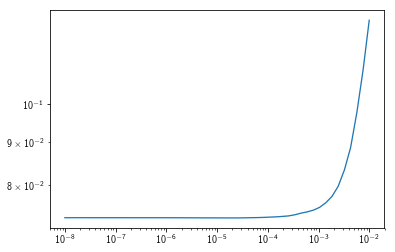

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
352 / 30000 iterations
applying cutoff
... took 40.236398015054874 seconds
(g,i)=(50,9) ...
find hyperparameter
current scores [0.07334971 0.0733497  0.07334969 0.07334967 0.07334964 0.0733496
 0.07334955 0.0733495  0.07334941 0.0733493  0.07334918 0.07334898
 0.07334872 0.07334838 0.07334794 0.07334737 0.07334666 0.07334532
 0.07334301 0.07333968 0.07333503 0.07332928 0.0733213  0.07330969
 0.07329743 0.07328617 0.07328184 0.07328017 0.0732888  0.07330299
 0.07330828 0.0733169  0.07332589 0.0733465  0.07339209 0.07343052
 0.07348598 0.07358869 0.07375692 0.07403946 0.07449386 0.07508109
 0.07592118 0.07732068 0.07977084

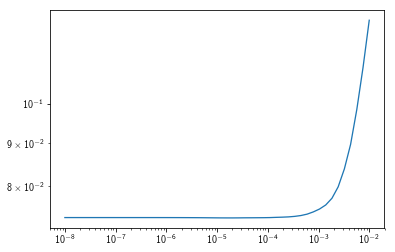

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
357 / 30000 iterations
applying cutoff
... took 40.115499419975094 seconds
(g,i)=(100,0) ...
find hyperparameter
current scores [0.03619771 0.0361977  0.03619769 0.03619768 0.03619766 0.03619762
 0.03619755 0.03619746 0.03619733 0.03619718 0.03619702 0.03619682
 0.03619654 0.03619619 0.03619567 0.03619488 0.03619373 0.0361923
 0.03619008 0.03618694 0.03618379 0.03618148 0.03618121 0.03618271
 0.036187   0.03619418 0.03620015 0.03621294 0.03623653 0.03625785
 0.03627043 0.03628388 0.03629449 0.03631517 0.03634894 0.03643213
 0.03652411 0.03663066 0.03682026 0.03711022 0.03760591 0.03820197
 0.03918597 0.04084062 0.0431015

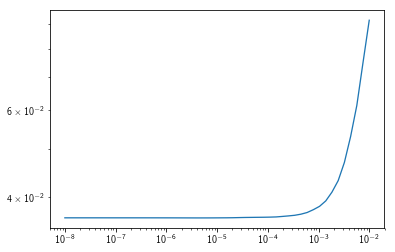

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
386 / 30000 iterations
applying cutoff
... took 44.17481456103269 seconds
(g,i)=(100,1) ...
find hyperparameter
current scores [0.03937471 0.03937466 0.03937459 0.0393745  0.03937439 0.03937423
 0.03937403 0.03937377 0.03937341 0.03937295 0.03937233 0.03937151
 0.0393705  0.03936922 0.03936749 0.03936528 0.0393625  0.03935906
 0.03935505 0.03934948 0.03934374 0.03933751 0.03932979 0.03932525
 0.03932408 0.0393222  0.03931776 0.03931223 0.03931075 0.03931945
 0.03933949 0.03937352 0.03941872 0.03947757 0.0395513  0.03959039
 0.03963994 0.03973156 0.03989414 0.04018052 0.04055527 0.04112298
 0.04207879 0.04345574 0.04584218

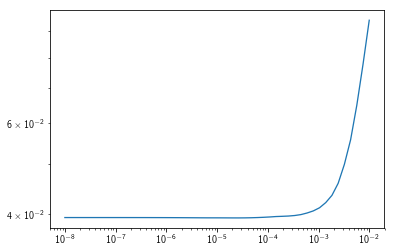

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
377 / 30000 iterations
applying cutoff
... took 44.06802400504239 seconds
(g,i)=(100,2) ...
find hyperparameter
current scores [0.0374475  0.03744752 0.03744754 0.03744758 0.03744762 0.03744768
 0.03744777 0.03744789 0.03744805 0.03744825 0.0374485  0.03744876
 0.03744912 0.03744958 0.03745019 0.03745106 0.037452   0.03745254
 0.03745252 0.03745182 0.03745199 0.03745331 0.03745132 0.03745079
 0.03744415 0.03743832 0.03743406 0.03743407 0.03744165 0.03745868
 0.0374728  0.03750282 0.03756111 0.0376695  0.03776306 0.03782195
 0.03789525 0.03798892 0.03816696 0.03848372 0.03898171 0.03960955
 0.0405462  0.04188393 0.0441949

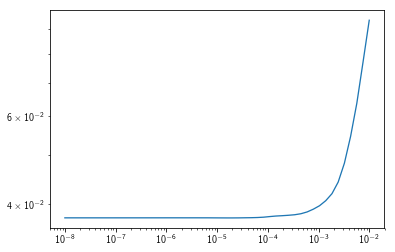

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
377 / 30000 iterations
applying cutoff
... took 43.60404277697671 seconds
(g,i)=(100,3) ...
find hyperparameter
current scores [0.03774631 0.0377463  0.03774628 0.03774625 0.03774622 0.03774615
 0.03774606 0.03774594 0.03774578 0.03774556 0.03774527 0.03774492
 0.03774449 0.0377439  0.03774313 0.03774215 0.03774125 0.03774019
 0.03773956 0.03773898 0.03773863 0.03773961 0.03774331 0.03774939
 0.03775582 0.03775144 0.03773791 0.03772537 0.03771166 0.03771226
 0.03772428 0.03774494 0.03777399 0.03781327 0.03785185 0.0379146
 0.03803236 0.03813722 0.03827001 0.0385212  0.03893495 0.03945551
 0.0403641  0.04184724 0.04403904

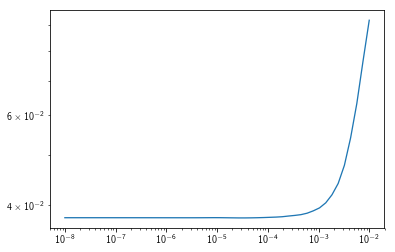

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.6826957952797274e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
344 / 30000 iterations
applying cutoff
... took 39.27381124906242 seconds
(g,i)=(100,4) ...
find hyperparameter
current scores [0.03690186 0.03690186 0.03690187 0.03690187 0.03690187 0.03690187
 0.03690187 0.03690187 0.03690187 0.03690187 0.03690189 0.03690191
 0.03690194 0.03690198 0.03690204 0.03690212 0.03690223 0.03690239
 0.03690275 0.03690333 0.0369041  0.03690523 0.03690752 0.03691325
 0.0369187  0.03692429 0.03692387 0.036917   0.03691421 0.03691114
 0.03691499 0.03694138 0.03698019 0.03702267 0.0371019  0.03717092
 0.03722969 0.03732218 0.03748216 0.03776834 0.03825879 0.0388429
 0.03980141 0.0411958  0.0434161 

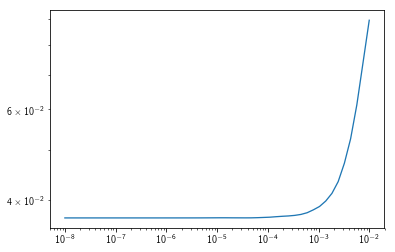

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
352 / 30000 iterations
applying cutoff
... took 39.08008012198843 seconds
(g,i)=(100,5) ...
find hyperparameter
current scores [0.04001502 0.04001501 0.04001499 0.04001497 0.04001493 0.04001489
 0.04001484 0.04001477 0.04001468 0.04001453 0.04001431 0.04001404
 0.04001367 0.04001316 0.04001251 0.04001175 0.0400108  0.04000924
 0.04000731 0.0400051  0.04000189 0.03999681 0.03999157 0.03998549
 0.03997886 0.03997663 0.03997372 0.03997649 0.03998162 0.03999106
 0.04000564 0.04003319 0.04009852 0.04016654 0.04023388 0.040274
 0.04031252 0.04039253 0.04053869 0.04078224 0.04109298 0.04163059
 0.04257966 0.04412703 0.04631645 0.0500496  0.0555

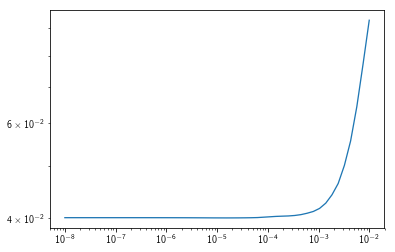

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5264179671752335e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
381 / 30000 iterations
applying cutoff
... took 42.16686517291237 seconds
(g,i)=(100,6) ...
find hyperparameter
current scores [0.03845218 0.0384522  0.03845222 0.03845224 0.03845228 0.03845232
 0.03845239 0.03845247 0.03845257 0.03845272 0.03845291 0.03845316
 0.0384535  0.03845396 0.03845463 0.03845554 0.03845676 0.03845852
 0.03846176 0.03846642 0.03847309 0.03847943 0.03848038 0.03847531
 0.03847274 0.03846508 0.03845718 0.0384503  0.03843936 0.03843368
 0.03843844 0.03845214 0.03846896 0.0384861  0.0385424  0.03861397
 0.03869023 0.03883097 0.03905019 0.03938391 0.03985285 0.04053484
 0.04155246 0.04314013 0.0457918

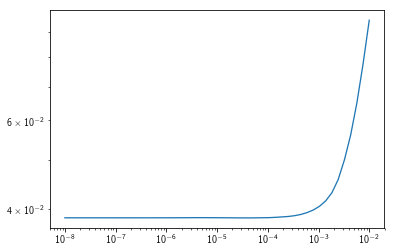

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.5564803062231284e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
358 / 30000 iterations
applying cutoff
... took 39.49995560897514 seconds
(g,i)=(100,7) ...
find hyperparameter
current scores [0.03992898 0.03992898 0.03992896 0.03992895 0.03992893 0.0399289
 0.03992886 0.03992881 0.03992874 0.03992867 0.03992856 0.03992841
 0.03992822 0.03992796 0.03992764 0.03992721 0.03992667 0.03992597
 0.03992515 0.03992426 0.03992377 0.0399236  0.03992405 0.03992716
 0.03993318 0.03994173 0.03995477 0.03997555 0.03998538 0.0400038
 0.0400136  0.04002156 0.04005876 0.04009458 0.04013636 0.04021978
 0.04037875 0.04059081 0.04072661 0.04098358 0.04143583 0.04194153
 0.04268269 0.04395678 0.04614764 

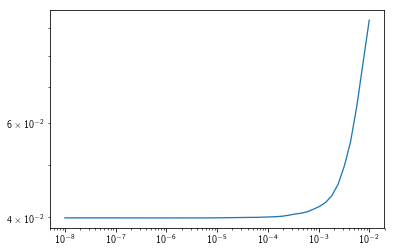

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
372 / 30000 iterations
applying cutoff
... took 45.48091643303633 seconds
(g,i)=(100,8) ...
find hyperparameter
current scores [0.0367323  0.03673229 0.03673229 0.03673228 0.03673227 0.03673226
 0.03673224 0.03673222 0.03673219 0.03673215 0.03673214 0.03673212
 0.03673209 0.03673201 0.03673191 0.03673181 0.03673165 0.03673161
 0.03673148 0.03673149 0.03673181 0.03673203 0.03673199 0.03673319
 0.03673576 0.0367409  0.03674738 0.03674438 0.03675243 0.03677298
 0.03680631 0.03684244 0.03687921 0.03691121 0.03696233 0.03706887
 0.03717043 0.03725532 0.0374124  0.03768752 0.03810599 0.0386476
 0.03955803 0.04089213 0.04313803 

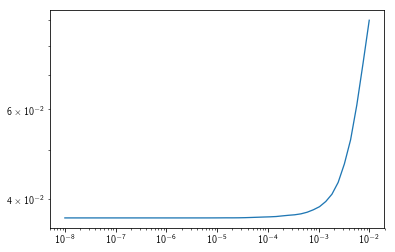

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5998587196060574e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
368 / 30000 iterations
applying cutoff
... took 41.84254969400354 seconds
(g,i)=(100,9) ...
find hyperparameter
current scores [0.03743253 0.03743253 0.03743254 0.03743255 0.03743257 0.03743258
 0.03743261 0.03743264 0.03743268 0.03743275 0.03743286 0.037433
 0.03743319 0.03743342 0.03743373 0.03743415 0.0374347  0.03743544
 0.03743631 0.03743722 0.03743752 0.03743736 0.03743641 0.03743326
 0.0374318  0.03742987 0.03743687 0.03743456 0.03742994 0.03743574
 0.03744357 0.0374676  0.03750291 0.03756928 0.03766835 0.03780642
 0.03787655 0.03793415 0.03806634 0.03832547 0.0387432  0.03925995
 0.04015988 0.04148912 0.04367656 

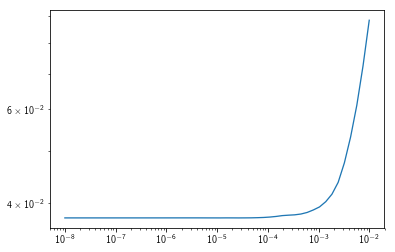

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.1513953993264481e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
368 / 30000 iterations
applying cutoff
... took 43.15244892903138 seconds
(g,i)=(200,0) ...
find hyperparameter
current scores [0.01799316 0.01799315 0.01799312 0.0179931  0.01799306 0.01799301
 0.01799295 0.01799286 0.01799275 0.01799259 0.01799241 0.01799219
 0.01799191 0.01799154 0.01799115 0.01799091 0.0179909  0.01799078
 0.01799054 0.01799016 0.01798937 0.01798766 0.01798689 0.01798696
 0.0179872  0.01799073 0.01799687 0.01800103 0.01800168 0.0180032
 0.0180102  0.01802466 0.01805138 0.01810111 0.01815504 0.0181864
 0.01823846 0.01832812 0.01848281 0.01874483 0.01906193 0.01961027
 0.02057178 0.02209652 0.02435442 

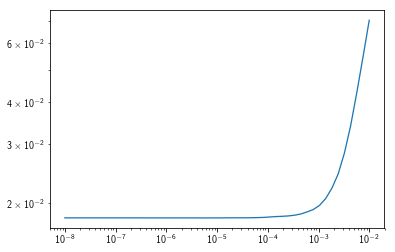

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
363 / 30000 iterations
applying cutoff
... took 41.484665579977445 seconds
(g,i)=(200,1) ...
find hyperparameter
current scores [0.01806225 0.01806225 0.01806226 0.01806226 0.01806227 0.01806228
 0.0180623  0.01806232 0.01806235 0.01806238 0.01806244 0.01806251
 0.0180626  0.01806268 0.0180628  0.01806292 0.01806293 0.01806292
 0.01806285 0.01806325 0.01806526 0.0180691  0.01807254 0.01807236
 0.01807543 0.01807801 0.01808229 0.0180866  0.01808748 0.01809078
 0.01810093 0.01813054 0.01814969 0.01817644 0.0182324  0.01831701
 0.01845869 0.0186707  0.01882108 0.01906857 0.01937366 0.01990265
 0.02083959 0.02222109 0.0244292

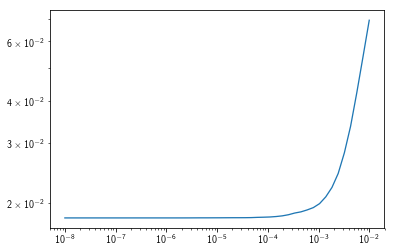

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
396 / 30000 iterations
applying cutoff
... took 43.626813238020986 seconds
(g,i)=(200,2) ...
find hyperparameter
current scores [0.01841595 0.01841594 0.01841591 0.01841588 0.01841584 0.01841578
 0.01841571 0.01841561 0.01841549 0.01841531 0.01841507 0.01841479
 0.01841442 0.01841397 0.0184134  0.01841264 0.01841161 0.01841037
 0.01840878 0.01840693 0.01840494 0.01840444 0.01840399 0.01840091
 0.0183962  0.01838957 0.01838693 0.01838413 0.01838654 0.01839601
 0.01840932 0.01843492 0.01847536 0.01851734 0.01857285 0.01866113
 0.018791   0.01891134 0.01910419 0.01942296 0.01986973 0.02044085
 0.0214299  0.02295798 0.02535081 0.02956985 0.0

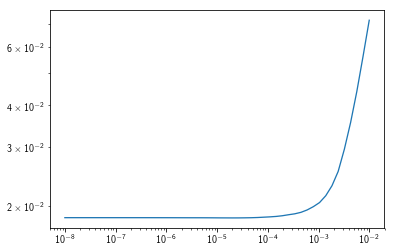

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
380 / 30000 iterations
applying cutoff
... took 44.46713770006318 seconds
(g,i)=(200,3) ...
find hyperparameter
current scores [0.01771365 0.01771365 0.01771364 0.01771363 0.01771362 0.01771361
 0.01771359 0.01771357 0.01771353 0.0177135  0.01771345 0.01771338
 0.01771324 0.01771305 0.0177128  0.01771253 0.01771271 0.01771295
 0.01771308 0.01771314 0.01771327 0.0177124  0.01771065 0.01771037
 0.01771399 0.01772214 0.01772357 0.01772157 0.01772624 0.01773124
 0.0177312  0.0177415  0.01776693 0.01780352 0.01784681 0.01790554
 0.0179598  0.01804587 0.01819954 0.01847175 0.01894448 0.01950061
 0.02045406 0.02190234 0.0242009

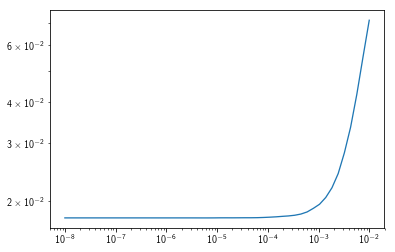

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
395 / 30000 iterations
applying cutoff
... took 43.885564751923084 seconds
(g,i)=(200,4) ...
find hyperparameter
current scores [0.01854602 0.01854599 0.01854595 0.0185459  0.01854584 0.01854575
 0.01854564 0.01854548 0.01854528 0.01854501 0.01854465 0.01854418
 0.01854356 0.01854277 0.01854186 0.01854085 0.0185402  0.01854003
 0.01854001 0.01854022 0.01854044 0.01854052 0.01854123 0.01854214
 0.01854338 0.01854431 0.01854602 0.01855032 0.01856295 0.01858222
 0.01859744 0.01862149 0.01865235 0.01869288 0.01873211 0.01877651
 0.018842   0.01895715 0.01915464 0.01949351 0.02002203 0.02072738
 0.02178155 0.02331555 0.025782

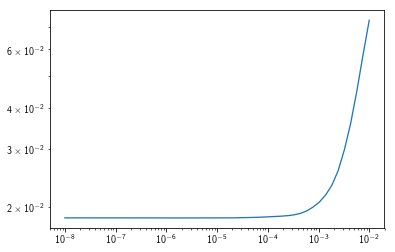

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5998587196060574e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
376 / 30000 iterations
applying cutoff
... took 42.42513866594527 seconds
(g,i)=(200,5) ...
find hyperparameter
current scores [0.01859646 0.01859644 0.01859642 0.01859639 0.01859636 0.01859631
 0.01859624 0.01859616 0.01859605 0.0185959  0.01859572 0.01859548
 0.01859515 0.01859472 0.01859412 0.01859325 0.01859233 0.01859174
 0.01859274 0.01859496 0.01859755 0.01859762 0.01859967 0.01860354
 0.01860584 0.01860682 0.01860817 0.01860889 0.01861231 0.01862384
 0.01864644 0.01867881 0.01871358 0.0187641  0.01882198 0.01888872
 0.01893941 0.01902811 0.01918435 0.01945978 0.01980423 0.02035114
 0.02129373 0.0226057  0.0247914

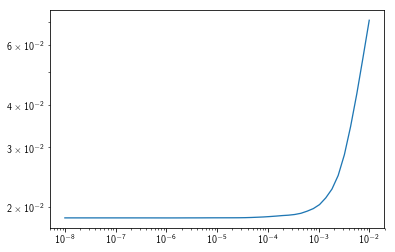

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
419 / 30000 iterations
applying cutoff
... took 49.37421340995934 seconds
(g,i)=(200,6) ...
find hyperparameter
current scores [0.01817738 0.01817738 0.01817737 0.01817737 0.01817735 0.01817733
 0.01817731 0.01817728 0.01817724 0.01817719 0.01817712 0.01817698
 0.01817678 0.01817652 0.01817617 0.0181757  0.01817515 0.01817419
 0.01817273 0.0181714  0.01816963 0.0181679  0.01816611 0.01816462
 0.01816308 0.01816187 0.01815894 0.01815738 0.01816191 0.01816558
 0.01817289 0.01818712 0.01821157 0.01825408 0.01829212 0.01831532
 0.018362   0.0184453  0.01859336 0.01883551 0.01914468 0.0196772
 0.02061334 0.02194991 0.0241717 

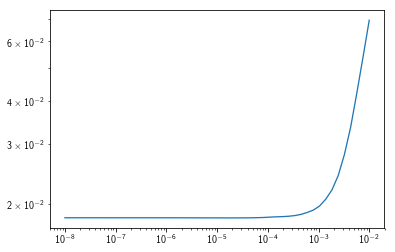

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.0235896477251556e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
381 / 30000 iterations
applying cutoff
... took 42.26167294604238 seconds
(g,i)=(200,7) ...
find hyperparameter
current scores [0.01840431 0.01840432 0.01840433 0.01840435 0.01840437 0.01840441
 0.01840445 0.01840451 0.01840458 0.01840469 0.01840482 0.018405
 0.01840525 0.01840557 0.01840595 0.01840636 0.0184066  0.01840724
 0.01840762 0.01840775 0.01840866 0.01841061 0.01841291 0.01841328
 0.01840658 0.01840648 0.01841104 0.01841745 0.01841944 0.01842205
 0.01842965 0.01844788 0.01849341 0.01854735 0.01859485 0.01866532
 0.01878317 0.01896926 0.01912865 0.01937643 0.01970077 0.02025874
 0.02125156 0.02280351 0.02513903 

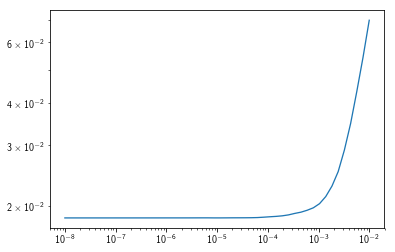

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
396 / 30000 iterations
applying cutoff
... took 43.77578968601301 seconds
(g,i)=(200,8) ...
find hyperparameter
current scores [0.01812439 0.01812438 0.01812437 0.01812436 0.01812434 0.01812431
 0.01812427 0.01812422 0.01812415 0.01812406 0.01812393 0.01812377
 0.01812358 0.01812336 0.01812306 0.01812273 0.01812227 0.01812171
 0.01812086 0.0181196  0.01811915 0.01811897 0.01811908 0.0181196
 0.01812169 0.01812508 0.01814268 0.01815123 0.01815542 0.01815721
 0.01816394 0.0181804  0.01821036 0.01826759 0.01835453 0.0184885
 0.01858046 0.01867389 0.01882097 0.01900563 0.01932171 0.01987646
 0.02085093 0.02239473 0.02472445 0.02848864 0.0338

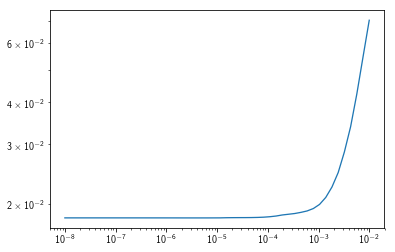

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
378 / 30000 iterations
applying cutoff
... took 41.9726644490147 seconds
(g,i)=(200,9) ...
find hyperparameter
current scores [0.01787738 0.01787737 0.01787736 0.01787735 0.01787734 0.01787732
 0.0178773  0.01787727 0.01787724 0.01787719 0.01787712 0.01787703
 0.0178769  0.01787673 0.01787644 0.01787609 0.01787589 0.01787576
 0.01787587 0.01787595 0.01787559 0.01787682 0.0178769  0.01787578
 0.01787443 0.0178754  0.01787773 0.0178808  0.01788564 0.01789514
 0.01791152 0.01794219 0.01798601 0.01805145 0.01810486 0.01819321
 0.01833789 0.01843734 0.01859956 0.0188817  0.01923982 0.01980274
 0.02078542 0.0224052  0.02468641 

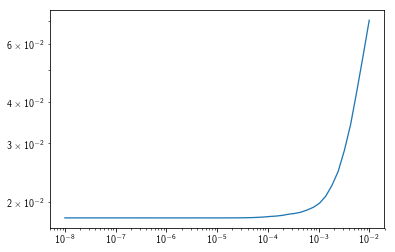

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
376 / 30000 iterations
applying cutoff
... took 41.343085644068196 seconds
(g,i)=(500,0) ...
find hyperparameter
current scores [0.00768271 0.00768271 0.00768271 0.0076827  0.00768268 0.00768266
 0.00768264 0.00768263 0.00768259 0.00768258 0.0076826  0.0076826
 0.00768265 0.00768276 0.00768297 0.00768309 0.00768314 0.00768277
 0.00768124 0.00767893 0.00767766 0.00767709 0.00767691 0.00767719
 0.00767991 0.00768372 0.00768551 0.00768743 0.0076916  0.00769658
 0.00770681 0.00772879 0.00776399 0.00780768 0.00785572 0.00793419
 0.00800118 0.00809332 0.00825535 0.00853901 0.00888221 0.00944422
 0.01044057 0.01206914 0.0143896  

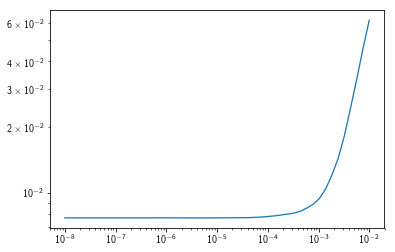

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
408 / 30000 iterations
applying cutoff
... took 45.039027293911204 seconds
(g,i)=(500,1) ...
find hyperparameter
current scores [0.00772418 0.00772416 0.00772415 0.00772413 0.00772409 0.00772405
 0.007724   0.00772393 0.00772384 0.00772374 0.0077236  0.00772346
 0.00772342 0.00772358 0.0077238  0.0077241  0.0077247  0.00772539
 0.00772578 0.00772498 0.00772447 0.00772397 0.007724   0.00772338
 0.00772176 0.00772063 0.00772096 0.00772451 0.00773    0.00773799
 0.00775006 0.00777176 0.0078014  0.00783318 0.00788158 0.00793124
 0.00798008 0.00806982 0.00822657 0.00850336 0.0088732  0.00942419
 0.01039075 0.01170984 0.0139614

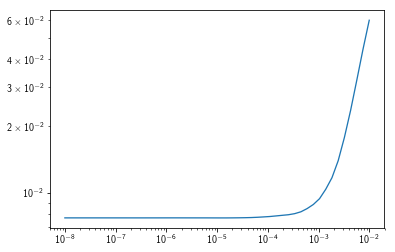

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.1513953993264481e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
391 / 30000 iterations
applying cutoff
... took 44.43167400197126 seconds
(g,i)=(500,2) ...
find hyperparameter
current scores [0.00759293 0.00759293 0.00759294 0.00759295 0.00759296 0.00759298
 0.00759299 0.00759299 0.00759301 0.00759307 0.00759321 0.00759336
 0.00759345 0.00759342 0.00759326 0.00759281 0.00759235 0.00759202
 0.00759201 0.00759109 0.00759075 0.00759063 0.00759172 0.00759066
 0.00758769 0.00758532 0.0075854  0.00758657 0.00759057 0.00759747
 0.00760673 0.00762058 0.00764788 0.00768765 0.0077357  0.00777259
 0.00782394 0.00791534 0.00807722 0.00834484 0.00868061 0.00924234
 0.01023692 0.01185814 0.0141131

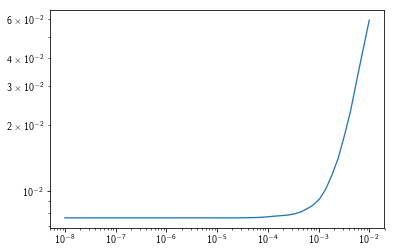

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.1513953993264481e-05, lambda=1.0)!
status 0: Optimization terminated successfully.
390 / 30000 iterations
applying cutoff
... took 43.99444958602544 seconds
(g,i)=(500,3) ...
find hyperparameter
current scores [0.00800573 0.00800571 0.0080057  0.00800568 0.00800566 0.00800563
 0.00800558 0.00800553 0.00800545 0.00800536 0.00800524 0.00800511
 0.00800494 0.00800473 0.00800444 0.00800403 0.00800348 0.00800343
 0.0080034  0.00800365 0.00800386 0.00800461 0.00800484 0.00800424
 0.00800259 0.00800318 0.00800749 0.0080115  0.00801723 0.00802255
 0.00802888 0.00804584 0.00807937 0.00811552 0.00815537 0.00822443
 0.00833386 0.00841065 0.00856064 0.00883372 0.00923413 0.00978202
 0.01074681 0.01206678 0.0143692

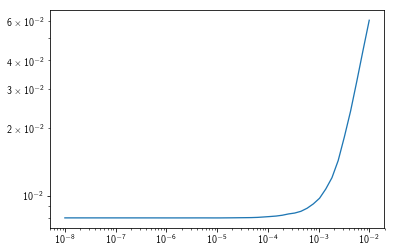

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
389 / 30000 iterations
applying cutoff
... took 44.031250896980055 seconds
(g,i)=(500,4) ...
find hyperparameter
current scores [0.00769777 0.00769778 0.0076978  0.00769781 0.00769783 0.00769786
 0.0076979  0.00769795 0.007698   0.00769806 0.00769809 0.00769817
 0.0076983  0.00769851 0.00769869 0.00769879 0.00769839 0.00769773
 0.00769706 0.00769575 0.00769429 0.00769302 0.00769273 0.00769355
 0.00769464 0.00769606 0.00769753 0.00770209 0.00771121 0.00771952
 0.00772953 0.00774861 0.00778122 0.00781896 0.00785905 0.00793433
 0.00800153 0.0080932  0.00825262 0.00853245 0.0089516  0.00950899
 0.0104847  0.01182532 0.01411984

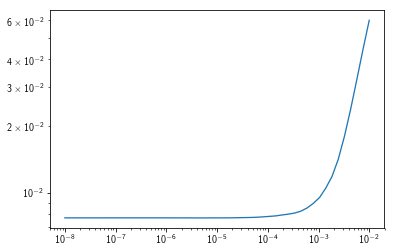

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=4.941713361323839e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
407 / 30000 iterations
applying cutoff
... took 45.68054111790843 seconds
(g,i)=(500,5) ...
find hyperparameter
current scores [0.00754593 0.00754594 0.00754594 0.00754593 0.00754594 0.00754595
 0.00754596 0.00754597 0.00754598 0.00754601 0.00754606 0.00754616
 0.00754632 0.00754652 0.0075468  0.00754718 0.00754775 0.00754802
 0.007548   0.00754776 0.00754795 0.00754865 0.00754865 0.00755141
 0.00755446 0.00755619 0.00755758 0.00756193 0.00756968 0.00758209
 0.00759859 0.00761473 0.00763098 0.00765544 0.00769801 0.00777335
 0.00787253 0.00795968 0.00811386 0.00838615 0.00881243 0.0093621
 0.01032873 0.01173889 0.01394195 

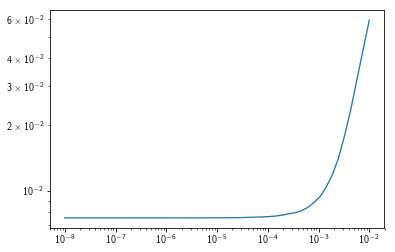

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.329951810515372e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
429 / 30000 iterations
applying cutoff
... took 48.511104389093816 seconds
(g,i)=(500,6) ...
find hyperparameter
current scores [0.00810903 0.00810899 0.00810895 0.00810891 0.0081088  0.0081087
 0.00810857 0.00810839 0.00810817 0.00810792 0.00810754 0.00810703
 0.00810641 0.00810604 0.00810562 0.00810512 0.0081046  0.00810427
 0.00810405 0.00810398 0.00810481 0.00810617 0.00810841 0.00811164
 0.00811765 0.00812621 0.00813445 0.00813893 0.0081462  0.00814865
 0.00815726 0.00817724 0.00820916 0.00825853 0.00831264 0.00839797
 0.00849778 0.0085876  0.00874863 0.00903581 0.00945339 0.01002772
 0.01104205 0.01254902 0.01491261

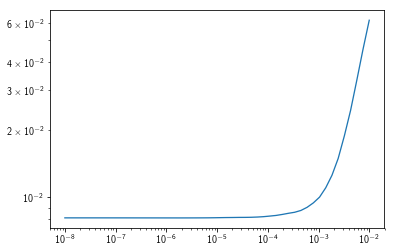

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
416 / 30000 iterations
applying cutoff
... took 45.88941576797515 seconds
(g,i)=(500,7) ...
find hyperparameter
current scores [0.00777078 0.00777077 0.00777076 0.00777074 0.00777071 0.00777068
 0.00777063 0.00777058 0.0077705  0.0077704  0.00777026 0.00777008
 0.00776985 0.00776956 0.00776907 0.00776856 0.00776807 0.00776774
 0.00776752 0.00776722 0.00776709 0.00776767 0.00776742 0.00776825
 0.00777087 0.00777483 0.00777769 0.00778306 0.0077933  0.00779983
 0.00780977 0.00782547 0.00784604 0.00787175 0.00791684 0.00799012
 0.00804008 0.00812672 0.00828135 0.00855501 0.00889051 0.00943914
 0.01039386 0.01173152 0.0139348

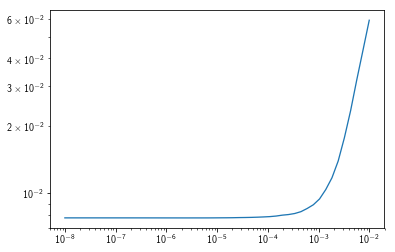

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
389 / 30000 iterations
applying cutoff
... took 42.9006530320039 seconds
(g,i)=(500,8) ...
find hyperparameter
current scores [0.00767168 0.00767167 0.00767165 0.00767163 0.00767161 0.00767158
 0.00767154 0.0076715  0.00767143 0.00767135 0.00767124 0.00767112
 0.0076709  0.00767066 0.00767041 0.00767017 0.0076699  0.00766966
 0.00766928 0.00766881 0.00766888 0.00767031 0.00767261 0.00767392
 0.00767305 0.00767342 0.00767345 0.00767408 0.00767663 0.00768121
 0.00768955 0.00770375 0.00772997 0.00777157 0.00782116 0.00788606
 0.00793963 0.00803312 0.0081968  0.00848094 0.00884136 0.00941695
 0.01042817 0.01208449 0.0144107  

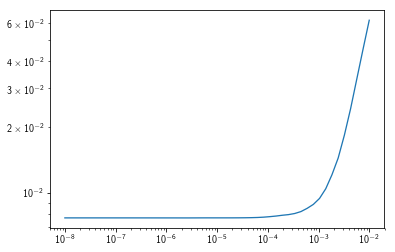

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
406 / 30000 iterations
applying cutoff
... took 45.775432164082304 seconds
(g,i)=(500,9) ...
find hyperparameter
current scores [0.00750778 0.00750778 0.00750778 0.00750778 0.00750778 0.00750779
 0.00750779 0.0075078  0.00750781 0.00750784 0.00750784 0.00750782
 0.00750778 0.00750767 0.00750746 0.00750717 0.00750645 0.00750509
 0.00750421 0.00750375 0.00750455 0.00750486 0.00750483 0.00750599
 0.0075073  0.00750936 0.00751205 0.00751789 0.00752494 0.00753018
 0.00753725 0.00755314 0.00758522 0.00763063 0.00767645 0.00776243
 0.00786552 0.00795422 0.00811228 0.00839149 0.0087504  0.00930161
 0.01027529 0.01164274 0.013962

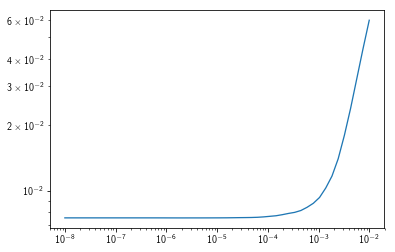

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
409 / 30000 iterations
applying cutoff
... took 45.31042534997687 seconds
(g,i)=(1000,0) ...
find hyperparameter
current scores [0.00399101 0.00399101 0.00399101 0.00399101 0.003991   0.00399098
 0.00399095 0.00399092 0.00399091 0.00399087 0.00399085 0.00399081
 0.00399072 0.00399042 0.00399005 0.00398953 0.00398893 0.00398861
 0.00398868 0.00398909 0.00399044 0.00399126 0.0039912  0.00399131
 0.0039916  0.00399183 0.0039926  0.00399529 0.00399982 0.00400651
 0.00401706 0.00403529 0.00406312 0.00411048 0.00416201 0.00421403
 0.00426622 0.00435809 0.00451974 0.00480411 0.00517901 0.00574249
 0.00673202 0.00816927 0.010463

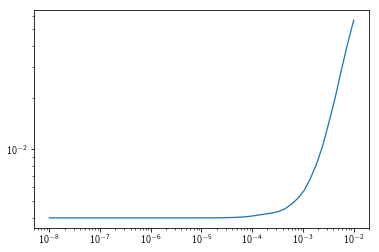

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
423 / 30000 iterations
applying cutoff
... took 48.026950159925036 seconds
(g,i)=(1000,1) ...
find hyperparameter
current scores [0.00377265 0.00377266 0.00377266 0.00377267 0.00377268 0.0037727
 0.00377272 0.00377275 0.00377279 0.00377278 0.00377269 0.00377256
 0.00377239 0.00377215 0.00377185 0.0037718  0.00377205 0.00377261
 0.00377352 0.00377532 0.00377706 0.00377935 0.00378052 0.00378071
 0.00378143 0.00378193 0.00378315 0.00378482 0.00378788 0.00379508
 0.00380935 0.00383313 0.00386386 0.00389139 0.00393728 0.00400998
 0.00406304 0.0041522  0.00430868 0.00458344 0.00502233 0.00557546
 0.00654395 0.00805492 0.010297

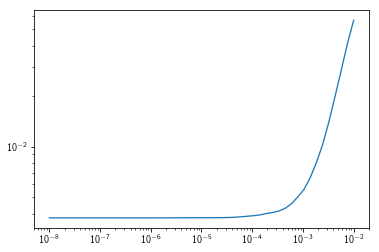

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.866488450042998e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
395 / 30000 iterations
applying cutoff
... took 44.97235851106234 seconds
(g,i)=(1000,2) ...
find hyperparameter
current scores [0.00388487 0.00388486 0.00388485 0.00388484 0.00388482 0.00388479
 0.00388476 0.00388472 0.00388467 0.0038846  0.00388451 0.00388439
 0.00388426 0.00388409 0.00388392 0.00388369 0.0038834  0.0038832
 0.00388328 0.00388382 0.00388471 0.00388575 0.00388655 0.00388724
 0.00388763 0.00388862 0.00389055 0.00389274 0.00389426 0.00389795
 0.00390899 0.00393014 0.00396699 0.00401733 0.00407071 0.00414944
 0.00421928 0.00430817 0.00446463 0.00474044 0.00513454 0.00568848
 0.00665965 0.00806345 0.01026834

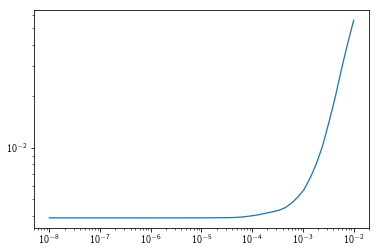

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
414 / 30000 iterations
applying cutoff
... took 45.626053479965776 seconds
(g,i)=(1000,3) ...
find hyperparameter
current scores [0.00377634 0.00377634 0.00377634 0.00377634 0.00377634 0.00377635
 0.00377635 0.00377635 0.00377636 0.00377637 0.00377637 0.00377637
 0.00377636 0.00377633 0.00377628 0.00377611 0.00377587 0.00377558
 0.00377539 0.00377642 0.00377768 0.00377671 0.00377596 0.00377635
 0.00377756 0.00377968 0.00378115 0.00378593 0.00378934 0.00379233
 0.00380048 0.0038196  0.00384887 0.00389259 0.00396055 0.00403884
 0.00413067 0.00422445 0.00438922 0.00467913 0.00505368 0.00562175
 0.00661896 0.00805767 0.01037

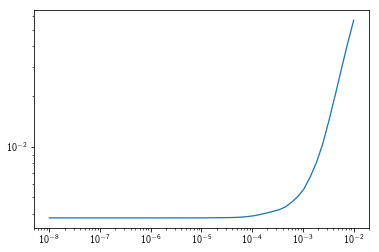

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5998587196060574e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
392 / 30000 iterations
applying cutoff
... took 46.269781608949415 seconds
(g,i)=(1000,4) ...
find hyperparameter
current scores [0.0038397  0.00383971 0.00383972 0.00383973 0.00383976 0.00383979
 0.00383984 0.0038399  0.00383998 0.00384008 0.00384023 0.00384043
 0.00384069 0.00384109 0.00384167 0.00384242 0.00384338 0.00384446
 0.00384538 0.00384499 0.00384453 0.00384536 0.00384706 0.00385034
 0.00385448 0.00385766 0.00385714 0.00385782 0.00385872 0.0038624
 0.00387425 0.00389139 0.00392313 0.00397855 0.00402617 0.00410603
 0.00424591 0.00435959 0.00451707 0.00479392 0.00516096 0.00571956
 0.0067003  0.00815957 0.010439

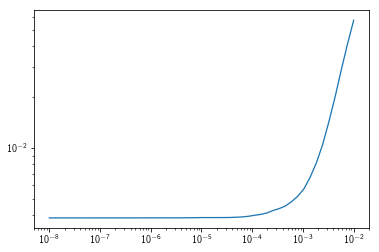

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
403 / 30000 iterations
applying cutoff
... took 45.65511354501359 seconds
(g,i)=(1000,5) ...
find hyperparameter
current scores [0.00373851 0.0037385  0.00373849 0.00373849 0.00373847 0.00373846
 0.00373844 0.00373842 0.00373839 0.00373835 0.00373825 0.00373815
 0.0037381  0.00373816 0.00373837 0.00373888 0.00373946 0.00374032
 0.0037407  0.00374054 0.00373975 0.0037394  0.00373859 0.00373822
 0.00373841 0.00373854 0.00374014 0.00374282 0.00374705 0.00375448
 0.00376693 0.00378823 0.00381519 0.0038393  0.00388407 0.00396594
 0.00404192 0.00413214 0.00429123 0.00457216 0.00498996 0.00555275
 0.00654044 0.00796965 0.01033238 0.01422593 0.0

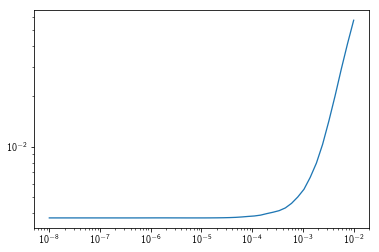

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.94705170255181e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
406 / 30000 iterations
applying cutoff
... took 45.35960537090432 seconds
(g,i)=(1000,6) ...
find hyperparameter
current scores [0.0038388  0.00383879 0.00383876 0.00383874 0.00383869 0.00383865
 0.00383858 0.00383849 0.00383836 0.00383821 0.00383804 0.00383786
 0.00383764 0.00383744 0.0038374  0.00383732 0.0038372  0.0038371
 0.00383697 0.00383675 0.00383665 0.00383697 0.00383823 0.00384102
 0.00384409 0.0038447  0.003848   0.00384962 0.00385088 0.00385479
 0.00386693 0.00388551 0.00391322 0.00396165 0.00403589 0.00412262
 0.0042252  0.00431747 0.00448096 0.00476693 0.00514575 0.00572363
 0.00674007 0.00835298 0.01066711 

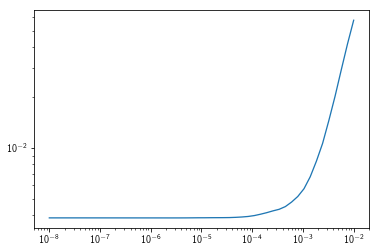

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
410 / 30000 iterations
applying cutoff
... took 45.784480503061786 seconds
(g,i)=(1000,7) ...
find hyperparameter
current scores [0.00365898 0.00365898 0.00365897 0.00365897 0.00365896 0.00365895
 0.00365893 0.00365892 0.0036589  0.00365887 0.00365884 0.00365878
 0.00365872 0.00365868 0.00365867 0.00365868 0.00365874 0.00365882
 0.00365871 0.00365845 0.0036583  0.00365885 0.00366054 0.00366418
 0.00366809 0.00367123 0.00367188 0.00367453 0.00367909 0.00368612
 0.00369826 0.00371767 0.00375101 0.0037914  0.00383274 0.00391059
 0.00397878 0.0040697  0.0042298  0.0045112  0.00492418 0.00548748
 0.0064742  0.00793316 0.010233

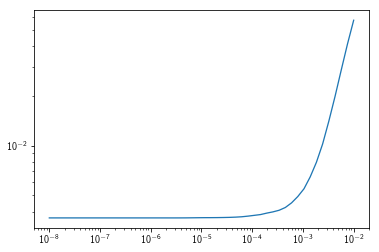

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
401 / 30000 iterations
applying cutoff
... took 45.72381291305646 seconds
(g,i)=(1000,8) ...
find hyperparameter
current scores [0.00374181 0.00374178 0.00374175 0.0037417  0.00374165 0.00374157
 0.00374147 0.00374137 0.00374122 0.00374105 0.00374092 0.00374082
 0.00374071 0.00374058 0.00374049 0.00374056 0.00374066 0.00374088
 0.00374138 0.00374239 0.00374318 0.00374369 0.00374436 0.00374497
 0.00374607 0.00374817 0.00374825 0.00374888 0.00375384 0.00376193
 0.0037749  0.00379493 0.00382378 0.00385684 0.00390762 0.00398471
 0.00404241 0.00413376 0.00429168 0.00457178 0.0049366  0.00549046
 0.00646705 0.00791774 0.0101645

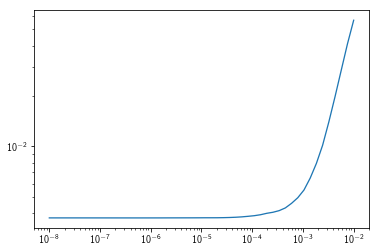

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=5.179474679231213e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
430 / 30000 iterations
applying cutoff
... took 47.72651742503513 seconds
(g,i)=(1000,9) ...
find hyperparameter
current scores [0.00360402 0.00360403 0.00360403 0.00360403 0.00360403 0.00360404
 0.00360404 0.00360405 0.00360406 0.00360407 0.00360415 0.00360423
 0.00360434 0.00360444 0.00360451 0.0036045  0.00360448 0.00360491
 0.00360577 0.00360721 0.00360942 0.00360987 0.00361006 0.00361136
 0.00361224 0.00361242 0.00361188 0.00361317 0.00361693 0.00362324
 0.00363463 0.00365496 0.00368815 0.00371674 0.00375902 0.00379429
 0.00384774 0.00394135 0.00410509 0.00439149 0.00476784 0.00533336
 0.00632533 0.00784538 0.0101192

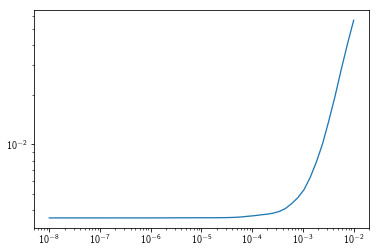

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
417 / 30000 iterations
applying cutoff
... took 48.683357055997476 seconds
(g,i)=(2000,0) ...
find hyperparameter
current scores [0.00201747 0.00201747 0.00201748 0.00201748 0.0020175  0.00201752
 0.00201754 0.00201757 0.00201758 0.00201758 0.00201757 0.00201754
 0.00201757 0.00201776 0.00201814 0.0020189  0.00201958 0.00201995
 0.00202048 0.00202097 0.00202121 0.0020209  0.00202052 0.00201998
 0.00201959 0.00201978 0.00202215 0.00202539 0.00203004 0.00203782
 0.00205141 0.00207325 0.00210164 0.00213264 0.0021783  0.00223922
 0.00228613 0.00237339 0.00252684 0.00279708 0.00317605 0.00371619
 0.0046655  0.00606401 0.00827532 0.01197645 0.

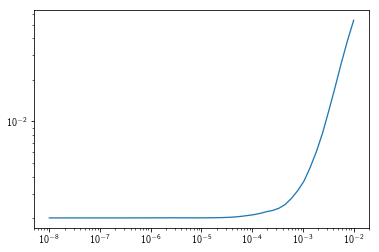

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
435 / 30000 iterations
applying cutoff
... took 49.608311926946044 seconds
(g,i)=(2000,1) ...
find hyperparameter
current scores [0.00195621 0.0019562  0.00195618 0.00195615 0.00195612 0.00195609
 0.00195605 0.00195599 0.00195592 0.00195585 0.00195578 0.00195564
 0.00195556 0.00195558 0.00195556 0.00195573 0.00195608 0.00195658
 0.00195687 0.0019571  0.0019569  0.00195647 0.00195668 0.00195725
 0.00195801 0.00195903 0.00196023 0.00196235 0.00196646 0.00197425
 0.00198856 0.00200955 0.00203527 0.00206406 0.00210982 0.00217081
 0.00222766 0.00232795 0.00250435 0.00280664 0.0032241  0.00382738
 0.00487096 0.00637811 0.00876821 0.01271487 0.

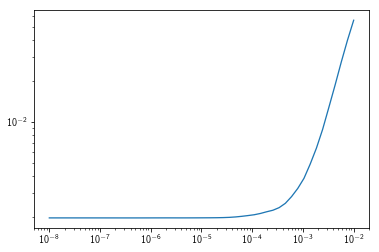

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=5.179474679231213e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
438 / 30000 iterations
applying cutoff
... took 50.025909706018865 seconds
(g,i)=(2000,2) ...
find hyperparameter
current scores [0.00201433 0.00201434 0.00201434 0.00201435 0.00201435 0.00201434
 0.00201434 0.00201433 0.00201433 0.00201431 0.00201429 0.00201426
 0.00201421 0.00201405 0.00201384 0.00201349 0.00201317 0.00201294
 0.00201247 0.00201211 0.00201174 0.00201122 0.00201071 0.00201041
 0.00201152 0.00201442 0.00201618 0.00201787 0.00202179 0.00202782
 0.0020392  0.00205821 0.00208836 0.00211554 0.00216005 0.00224218
 0.00232954 0.002418   0.00257345 0.0028471  0.00322266 0.00376957
 0.00473087 0.00616291 0.008435

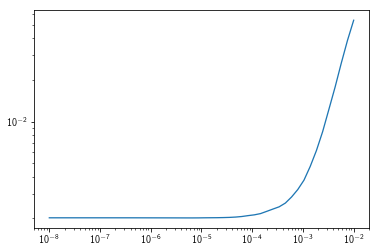

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
404 / 30000 iterations
applying cutoff
... took 44.53588533797301 seconds
(g,i)=(2000,3) ...
find hyperparameter
current scores [0.00198681 0.00198681 0.00198681 0.00198681 0.00198682 0.00198682
 0.00198682 0.00198682 0.00198683 0.00198685 0.00198688 0.00198696
 0.00198707 0.00198727 0.00198752 0.00198779 0.00198794 0.00198797
 0.0019882  0.00198837 0.00198858 0.00198856 0.0019888  0.00198997
 0.00199118 0.0019924  0.00199402 0.00199632 0.00199958 0.00200592
 0.00201793 0.00203951 0.00207548 0.00211632 0.0021616  0.00224477
 0.00231612 0.00240969 0.00257354 0.0028611  0.0032373  0.00380613
 0.00480369 0.00619804 0.008521

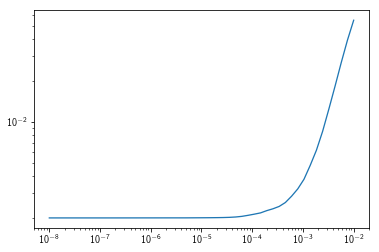

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
425 / 30000 iterations
applying cutoff
... took 47.52335809392389 seconds
(g,i)=(2000,4) ...
find hyperparameter
current scores [0.00197533 0.00197532 0.0019753  0.00197527 0.00197524 0.00197518
 0.00197516 0.00197514 0.00197512 0.00197513 0.00197515 0.00197515
 0.00197508 0.00197505 0.00197493 0.00197483 0.00197432 0.00197352
 0.00197278 0.00197219 0.00197184 0.00197141 0.00197113 0.00197083
 0.00197056 0.00197135 0.00197334 0.00197591 0.00198019 0.00198781
 0.00200038 0.0020201  0.00204737 0.00207513 0.0021229  0.00220459
 0.00226273 0.00235483 0.00251759 0.00279261 0.00313333 0.00370392
 0.00470944 0.00627345 0.00862564 0.01257955 0.0

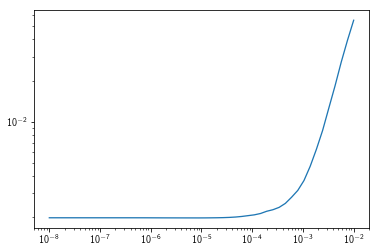

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
398 / 30000 iterations
applying cutoff
... took 53.108712985995226 seconds
(g,i)=(2000,5) ...
find hyperparameter
current scores [0.00193041 0.0019304  0.00193039 0.00193038 0.00193037 0.00193035
 0.00193033 0.00193029 0.00193025 0.0019302  0.00193008 0.00193001
 0.00193001 0.00192999 0.00193003 0.00192982 0.00192959 0.00192938
 0.00192924 0.00192929 0.00192958 0.00193002 0.00193098 0.00193187
 0.00193322 0.00193478 0.00193596 0.00193858 0.00194285 0.00195122
 0.0019649  0.00198667 0.00202261 0.00207001 0.00212143 0.00220413
 0.00225588 0.00234313 0.0024969  0.00276772 0.00313212 0.00367296
 0.00462942 0.00600256 0.0082176

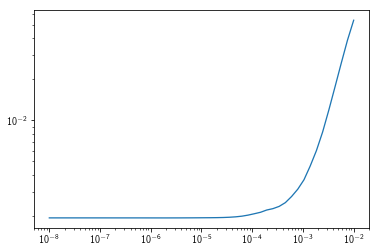

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.5998587196060574e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
429 / 30000 iterations
applying cutoff
... took 55.98749307799153 seconds
(g,i)=(2000,6) ...
find hyperparameter
current scores [0.00183592 0.00183593 0.00183595 0.00183596 0.00183598 0.00183601
 0.00183604 0.00183609 0.00183617 0.00183624 0.00183634 0.00183646
 0.0018366  0.00183668 0.00183679 0.00183665 0.0018363  0.00183582
 0.0018359  0.0018364  0.00183732 0.00183907 0.00183996 0.00183904
 0.00183828 0.00183819 0.00183922 0.00184143 0.00184541 0.00185235
 0.00186465 0.00188201 0.0019076  0.00193813 0.00198344 0.00206093
 0.00211379 0.00220038 0.00235368 0.00262404 0.00296296 0.00350537
 0.00446062 0.00593926 0.008162

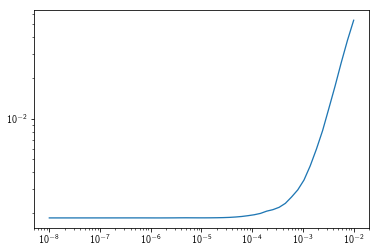

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
433 / 30000 iterations
applying cutoff
... took 49.22817127208691 seconds
(g,i)=(2000,7) ...
find hyperparameter
current scores [0.00185904 0.00185904 0.00185905 0.00185904 0.00185904 0.00185902
 0.001859   0.001859   0.00185898 0.00185897 0.00185892 0.00185883
 0.00185873 0.00185863 0.0018586  0.00185857 0.00185859 0.00185867
 0.00185882 0.00185905 0.0018594  0.00185971 0.00185951 0.00185884
 0.00185836 0.00185873 0.00185953 0.00186136 0.00186511 0.00187279
 0.00188566 0.00190401 0.00193331 0.00197721 0.00202342 0.00210065
 0.00218144 0.00226793 0.00242636 0.00270681 0.00317036 0.00373716
 0.0047263  0.00616533 0.008481

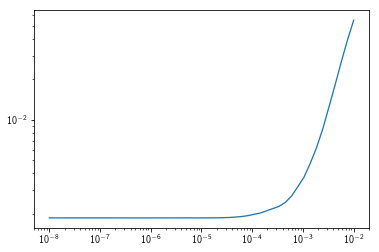

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=8.68511373751352e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
396 / 30000 iterations
applying cutoff
... took 45.084918407024816 seconds
(g,i)=(2000,8) ...
find hyperparameter
current scores [0.00198213 0.00198213 0.00198214 0.00198215 0.00198217 0.00198219
 0.00198222 0.00198225 0.00198226 0.00198227 0.00198229 0.00198227
 0.0019823  0.0019821  0.0019818  0.00198166 0.00198152 0.00198145
 0.00198193 0.00198278 0.00198371 0.00198433 0.00198431 0.0019846
 0.00198563 0.00198651 0.00198849 0.00199161 0.00199692 0.00200439
 0.00201722 0.0020361  0.0020661  0.00210291 0.0021488  0.00223184
 0.00228816 0.00238469 0.00255446 0.00283954 0.00321802 0.00380028
 0.00481655 0.00624352 0.00858207

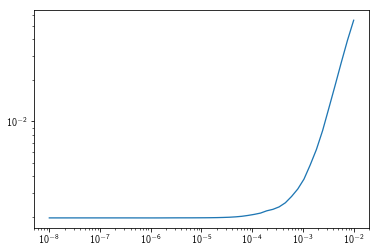

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
420 / 30000 iterations
applying cutoff
... took 47.21554320899304 seconds
(g,i)=(2000,9) ...
find hyperparameter
current scores [0.00194655 0.00194654 0.00194652 0.00194649 0.00194645 0.00194641
 0.00194638 0.00194633 0.00194627 0.00194618 0.00194603 0.00194586
 0.00194564 0.00194541 0.00194516 0.001945   0.00194496 0.00194492
 0.00194481 0.00194464 0.00194446 0.00194432 0.00194449 0.00194498
 0.00194652 0.00194922 0.0019529  0.00195486 0.00195939 0.00196555
 0.00197306 0.00198918 0.0020218  0.00206904 0.00211689 0.00217552
 0.00222589 0.00231503 0.00247309 0.00275274 0.00314294 0.00370298
 0.00468934 0.00624191 0.008489

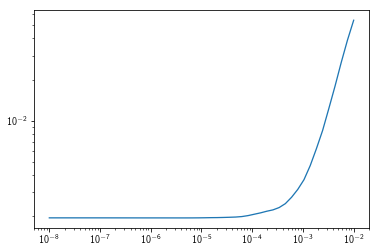

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
389 / 30000 iterations
applying cutoff
... took 44.92686690296978 seconds
(g,i)=(5000,0) ...
find hyperparameter
current scores [0.00073507 0.00073507 0.00073506 0.00073505 0.00073505 0.00073504
 0.00073502 0.00073499 0.00073495 0.00073491 0.00073493 0.00073491
 0.00073489 0.00073485 0.00073483 0.00073479 0.0007346  0.00073441
 0.00073432 0.00073403 0.00073355 0.00073327 0.00073302 0.00073302
 0.00073318 0.0007339  0.00073552 0.00073799 0.00074228 0.00074992
 0.00076261 0.00078311 0.00081376 0.00084812 0.00089299 0.0009656
 0.00101809 0.00111091 0.00127426 0.00156155 0.00196683 0.00253748
 0.00353956 0.00501381 0.00733318

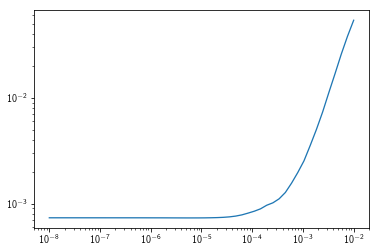

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
399 / 30000 iterations
applying cutoff
... took 44.02425794303417 seconds
(g,i)=(5000,1) ...
find hyperparameter
current scores [0.00080101 0.00080101 0.00080101 0.00080101 0.00080101 0.00080101
 0.00080101 0.000801   0.000801   0.00080101 0.00080101 0.00080102
 0.00080104 0.00080107 0.00080112 0.00080121 0.00080134 0.00080158
 0.00080193 0.00080259 0.00080325 0.00080474 0.00080647 0.00080685
 0.00080791 0.00080861 0.00080976 0.00081151 0.00081639 0.00082491
 0.00083575 0.00085698 0.00089273 0.00093784 0.00098762 0.00107672
 0.00116901 0.00126473 0.00143522 0.001728   0.0021063  0.0027059
 0.00376237 0.00528413 0.0077547

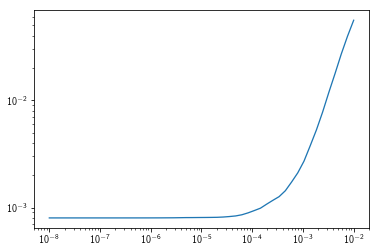

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=7.196856730011513e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
438 / 30000 iterations
applying cutoff
... took 48.366296559921466 seconds
(g,i)=(5000,2) ...
find hyperparameter
current scores [0.00076194 0.00076193 0.00076192 0.00076191 0.00076189 0.00076187
 0.00076184 0.00076182 0.00076175 0.00076166 0.00076155 0.0007615
 0.00076148 0.00076146 0.00076136 0.00076127 0.00076127 0.00076146
 0.00076158 0.00076159 0.00076162 0.0007618  0.00076212 0.00076248
 0.00076301 0.00076383 0.00076518 0.00076757 0.0007716  0.00077804
 0.00078885 0.00080809 0.00083588 0.00086929 0.00091282 0.00099024
 0.00104561 0.00113447 0.00129125 0.0015678  0.00195871 0.00250933
 0.00347802 0.00495703 0.0072106

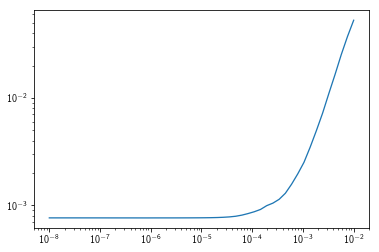

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=9.102981779915227e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
427 / 30000 iterations
applying cutoff
... took 47.078548416960984 seconds
(g,i)=(5000,3) ...
find hyperparameter
current scores [0.00083526 0.00083526 0.00083526 0.00083525 0.00083525 0.00083525
 0.00083525 0.00083526 0.00083526 0.00083528 0.00083532 0.00083534
 0.00083539 0.00083546 0.00083544 0.00083531 0.00083521 0.00083522
 0.00083518 0.00083491 0.0008345  0.00083418 0.00083421 0.00083471
 0.00083543 0.00083633 0.00083799 0.00084114 0.00084591 0.00085307
 0.00086416 0.00088358 0.00091238 0.00094353 0.00098676 0.00106604
 0.00113943 0.00122901 0.00138655 0.00166325 0.00205436 0.00260771
 0.00357964 0.00505583 0.007322

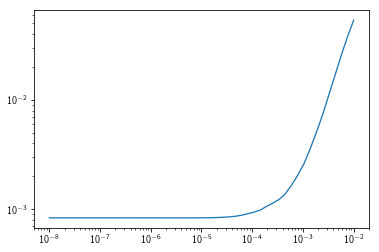

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
405 / 30000 iterations
applying cutoff
... took 46.080441543017514 seconds
(g,i)=(5000,4) ...
find hyperparameter
current scores [0.0008331  0.0008331  0.00083309 0.00083308 0.00083307 0.00083306
 0.00083307 0.00083307 0.00083305 0.00083306 0.00083308 0.00083312
 0.00083318 0.00083323 0.0008333  0.00083332 0.00083329 0.00083329
 0.00083327 0.00083331 0.00083311 0.00083286 0.00083259 0.00083254
 0.00083301 0.0008337  0.0008349  0.00083716 0.00084115 0.00084785
 0.00085838 0.00087462 0.00090305 0.00093454 0.00098003 0.00105669
 0.00111164 0.001209   0.00138144 0.00168629 0.00210226 0.00270301
 0.00375958 0.00534018 0.007782

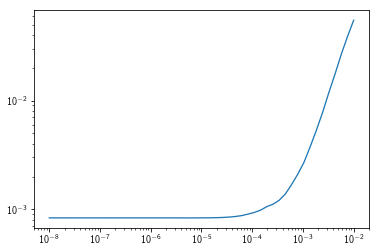

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.5512855685955095e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
400 / 30000 iterations
applying cutoff
... took 45.12069395999424 seconds
(g,i)=(5000,5) ...
find hyperparameter
current scores [0.00081869 0.0008187  0.00081871 0.00081872 0.00081873 0.00081875
 0.00081875 0.00081875 0.00081873 0.00081869 0.00081867 0.00081864
 0.00081859 0.00081855 0.0008185  0.00081846 0.00081841 0.00081837
 0.00081808 0.00081765 0.00081735 0.00081726 0.00081735 0.00081758
 0.00081805 0.00081904 0.00082044 0.00082307 0.00082763 0.00083439
 0.00084567 0.00086527 0.00089177 0.00091786 0.00096265 0.00102383
 0.00107445 0.00116383 0.00132147 0.00159925 0.0019827  0.00253514
 0.00350603 0.00491761 0.007199

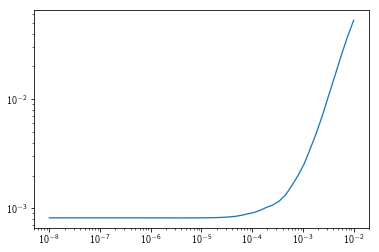

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
415 / 30000 iterations
applying cutoff
... took 47.302594501990825 seconds
(g,i)=(5000,6) ...
find hyperparameter
current scores [0.00078988 0.00078988 0.00078987 0.00078987 0.00078987 0.00078986
 0.00078985 0.00078984 0.00078983 0.00078984 0.00078984 0.00078986
 0.00078983 0.00078981 0.00078985 0.00078988 0.00078989 0.00078998
 0.00079001 0.00079003 0.00079003 0.00079024 0.00079069 0.00079123
 0.0007916  0.00079281 0.00079376 0.00079618 0.00080055 0.00080673
 0.00081757 0.00083699 0.00086653 0.00089829 0.00094176 0.00102274
 0.00108192 0.00116967 0.00132446 0.0015973  0.00197832 0.00252714
 0.00349245 0.00488866 0.007142

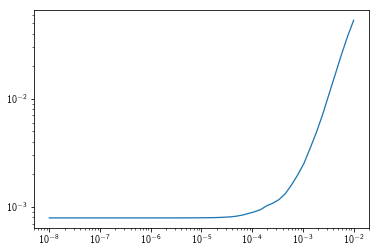

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.906939937054621e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
425 / 30000 iterations
applying cutoff
... took 47.29052739404142 seconds
(g,i)=(5000,7) ...
find hyperparameter
current scores [0.00078809 0.00078808 0.00078807 0.00078805 0.00078803 0.000788
 0.00078797 0.00078792 0.00078787 0.00078781 0.00078777 0.0007877
 0.00078776 0.00078794 0.00078823 0.00078861 0.00078875 0.00078874
 0.0007885  0.00078825 0.00078812 0.00078822 0.00078852 0.00078912
 0.00079026 0.00079162 0.00079369 0.00079644 0.00080042 0.00080705
 0.00081835 0.00083757 0.00086447 0.00089244 0.00094077 0.0009988
 0.00105143 0.00114423 0.00130762 0.00159537 0.00196472 0.00253999
 0.00355094 0.00501391 0.00740142 0.

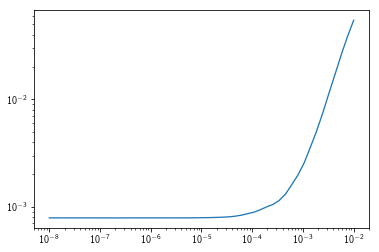

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.2229964825261955e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
441 / 30000 iterations
applying cutoff
... took 49.881910733063705 seconds
(g,i)=(5000,8) ...
find hyperparameter
current scores [0.00079069 0.00079069 0.00079067 0.00079065 0.00079063 0.00079062
 0.00079058 0.00079056 0.00079052 0.00079046 0.0007905  0.00079058
 0.00079062 0.00079062 0.00079062 0.00079068 0.0007908  0.00079076
 0.00079067 0.00079052 0.00079029 0.00079012 0.00079015 0.00079021
 0.00079036 0.00079111 0.00079268 0.00079498 0.00079902 0.00080606
 0.00081723 0.00083658 0.0008645  0.0008986  0.0009423  0.00101728
 0.00106905 0.00115828 0.00131544 0.00159207 0.00196593 0.00251577
 0.00348237 0.00490135 0.00715

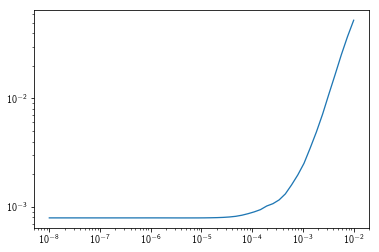

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.727593720314938e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
414 / 30000 iterations
applying cutoff
... took 49.434357606922276 seconds
(g,i)=(5000,9) ...
find hyperparameter
current scores [0.00079553 0.00079553 0.00079554 0.00079554 0.00079553 0.00079552
 0.0007955  0.00079547 0.00079546 0.00079544 0.00079545 0.00079548
 0.00079547 0.00079544 0.00079544 0.0007955  0.00079552 0.00079561
 0.00079579 0.0007959  0.00079584 0.00079569 0.00079575 0.000796
 0.00079662 0.000798   0.00079938 0.00080118 0.00080374 0.00080998
 0.00082036 0.00083717 0.00086343 0.00090423 0.00094691 0.00102576
 0.0010955  0.0011825  0.00133664 0.00160771 0.00198354 0.00252596
 0.00347981 0.00484648 0.00708594

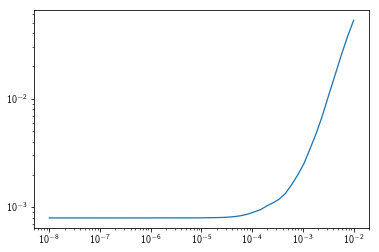

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2648552168552957e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
445 / 30000 iterations
applying cutoff
... took 50.59337213099934 seconds
(g,i)=(10000,0) ...
find hyperparameter
current scores [0.00041536 0.00041536 0.00041537 0.00041539 0.0004154  0.00041541
 0.00041542 0.00041545 0.00041548 0.00041553 0.00041558 0.00041564
 0.00041569 0.00041575 0.00041585 0.00041585 0.00041586 0.0004159
 0.00041597 0.00041606 0.00041624 0.00041639 0.00041658 0.000417
 0.00041746 0.00041837 0.00042036 0.00042311 0.00042776 0.0004356
 0.00044809 0.00046871 0.0004977  0.00053466 0.00057895 0.00066074
 0.00072956 0.00082817 0.00100202 0.00129892 0.00169522 0.00229485
 0.00333777 0.00482643 0.0072489  

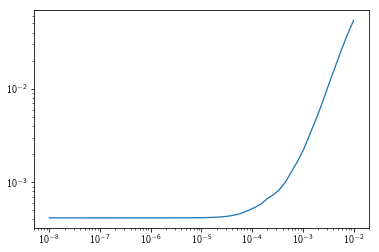

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
453 / 30000 iterations
applying cutoff
... took 49.95522196998354 seconds
(g,i)=(10000,1) ...
find hyperparameter
current scores [0.00040396 0.00040394 0.00040393 0.0004039  0.00040388 0.00040386
 0.00040383 0.00040379 0.00040374 0.00040372 0.00040368 0.00040366
 0.00040363 0.00040361 0.00040361 0.00040358 0.00040357 0.00040365
 0.00040373 0.00040364 0.00040363 0.00040379 0.0004041  0.00040466
 0.00040508 0.00040568 0.0004072  0.00040972 0.000414   0.00042063
 0.00043247 0.00045319 0.00048852 0.00052467 0.00057266 0.00065926
 0.0007215  0.00082018 0.00099453 0.00129511 0.00167883 0.0022803
 0.00333674 0.00492228 0.00737735 0.01145527 0.0

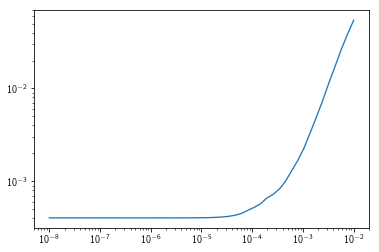

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=9.102981779915227e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
439 / 30000 iterations
applying cutoff
... took 48.28684487007558 seconds
(g,i)=(10000,2) ...
find hyperparameter
current scores [0.00043201 0.000432   0.00043199 0.00043198 0.00043197 0.00043194
 0.00043192 0.0004319  0.00043185 0.00043182 0.00043181 0.0004318
 0.00043182 0.00043186 0.00043191 0.000432   0.00043217 0.00043238
 0.00043246 0.00043241 0.00043265 0.00043316 0.00043355 0.00043393
 0.00043477 0.00043655 0.00043817 0.00044095 0.00044551 0.00045258
 0.00046411 0.00048425 0.00051443 0.00054626 0.0005916  0.00067555
 0.00074478 0.00083959 0.00100695 0.00130077 0.00168738 0.00227153
 0.00329764 0.00481281 0.0072276

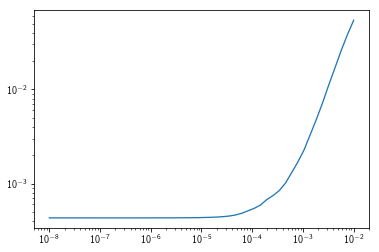

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.2229964825261955e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
439 / 30000 iterations
applying cutoff
... took 49.673644570983015 seconds
(g,i)=(10000,3) ...
find hyperparameter
current scores [0.00039971 0.00039972 0.00039972 0.00039972 0.00039972 0.00039972
 0.00039973 0.00039975 0.00039977 0.00039979 0.00039979 0.0003998
 0.00039988 0.00040002 0.00040009 0.00040018 0.0004004  0.00040072
 0.00040106 0.00040102 0.00040094 0.000401   0.0004011  0.00040128
 0.00040192 0.00040284 0.00040436 0.00040697 0.00041151 0.00041932
 0.00043278 0.00045119 0.00047885 0.00050878 0.00055463 0.00062846
 0.00067879 0.00076773 0.00092479 0.00120189 0.0015744  0.00212651
 0.00309765 0.00454871 0.00682

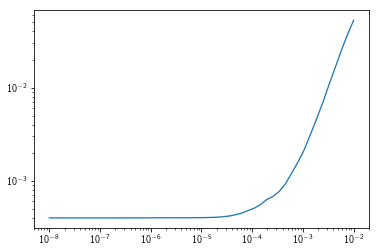

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
441 / 30000 iterations
applying cutoff
... took 49.798466169973835 seconds
(g,i)=(10000,4) ...
find hyperparameter
current scores [0.00041698 0.00041696 0.00041696 0.00041696 0.00041697 0.00041697
 0.00041698 0.00041698 0.00041698 0.00041697 0.00041694 0.00041691
 0.00041689 0.0004169  0.00041695 0.00041693 0.00041693 0.00041685
 0.00041681 0.00041676 0.00041679 0.00041703 0.00041731 0.00041778
 0.00041816 0.00041928 0.00042055 0.00042314 0.00042798 0.00043612
 0.0004499  0.00047117 0.00050074 0.00053049 0.00057552 0.00065844
 0.0007208  0.00081312 0.00097586 0.00126223 0.00165128 0.00222202
 0.00322479 0.00469358 0.0070521  0.01095816 0

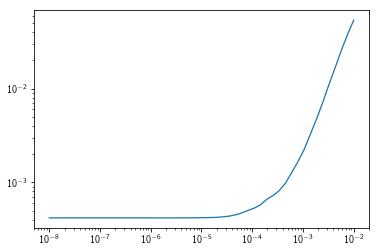

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
416 / 30000 iterations
applying cutoff
... took 49.259246058994904 seconds
(g,i)=(10000,5) ...
find hyperparameter
current scores [0.00039618 0.00039617 0.00039617 0.00039616 0.00039615 0.00039613
 0.00039612 0.00039612 0.00039609 0.00039606 0.00039604 0.00039604
 0.00039608 0.00039613 0.0003962  0.00039634 0.00039656 0.00039681
 0.00039718 0.00039771 0.00039828 0.00039831 0.00039824 0.0003987
 0.00039925 0.00039987 0.00040134 0.00040403 0.00040825 0.00041519
 0.0004268  0.0004465  0.00047778 0.00051542 0.00055934 0.0006333
 0.00068326 0.00077123 0.00092623 0.0011992  0.0015782  0.00212636
 0.00308993 0.00452141 0.006787

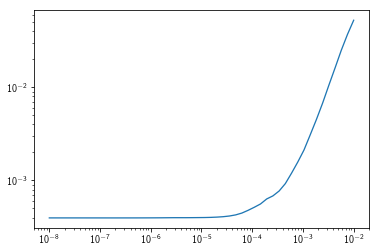

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.67683293681101e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
439 / 30000 iterations
applying cutoff
... took 49.98342177295126 seconds
(g,i)=(10000,6) ...
find hyperparameter
current scores [0.00042263 0.00042263 0.00042263 0.00042263 0.00042264 0.00042264
 0.00042264 0.00042265 0.00042266 0.00042269 0.00042273 0.00042275
 0.00042279 0.00042277 0.00042273 0.00042267 0.00042253 0.00042225
 0.00042195 0.00042162 0.00042135 0.00042152 0.00042198 0.00042266
 0.00042322 0.00042403 0.00042582 0.00042855 0.0004331  0.0004408
 0.00045259 0.00047186 0.00049886 0.00052811 0.00057356 0.00064721
 0.00069835 0.0007885  0.00094771 0.00122856 0.00160836 0.00216787
 0.00315195 0.00455376 0.00684523

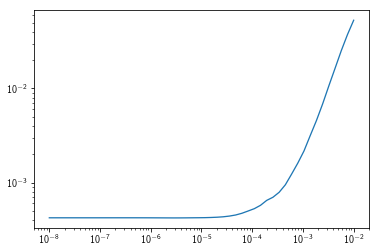

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
424 / 30000 iterations
applying cutoff
... took 47.84155249397736 seconds
(g,i)=(10000,7) ...
find hyperparameter
current scores [0.00039744 0.00039743 0.00039741 0.0003974  0.00039738 0.00039736
 0.00039735 0.00039731 0.00039727 0.00039722 0.00039718 0.00039713
 0.00039706 0.00039696 0.00039687 0.00039677 0.00039668 0.00039665
 0.00039669 0.00039692 0.00039704 0.0003971  0.00039727 0.00039751
 0.00039791 0.00039915 0.00040059 0.00040236 0.00040646 0.00041374
 0.00042511 0.0004448  0.00047457 0.00050738 0.0005517  0.00063585
 0.00070434 0.00079622 0.00095866 0.00124489 0.00161624 0.00218452
 0.00318455 0.00464729 0.006994

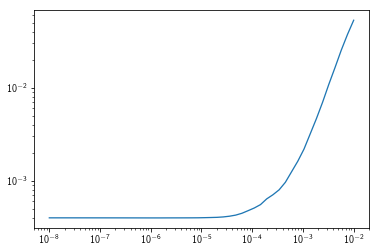

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2067926406393288e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
423 / 30000 iterations
applying cutoff
... took 47.980367199052125 seconds
(g,i)=(10000,8) ...
find hyperparameter
current scores [0.00041085 0.00041085 0.00041084 0.00041082 0.0004108  0.00041078
 0.00041075 0.00041072 0.00041071 0.0004107  0.00041069 0.00041068
 0.00041068 0.00041069 0.00041071 0.00041073 0.00041078 0.00041087
 0.00041104 0.00041132 0.00041162 0.00041166 0.00041179 0.00041217
 0.00041284 0.0004137  0.000415   0.00041679 0.00042044 0.00042752
 0.00043883 0.00045881 0.00048911 0.00052892 0.00057205 0.00065047
 0.00072826 0.0008183  0.00097778 0.0012601  0.00163822 0.00219781
 0.00318268 0.00465711 0.0069

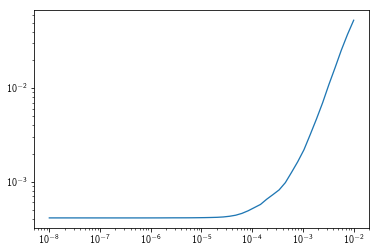

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.94705170255181e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
437 / 30000 iterations
applying cutoff
... took 50.061097597004846 seconds
(g,i)=(10000,9) ...
find hyperparameter
current scores [0.00041602 0.00041602 0.00041602 0.00041602 0.00041601 0.000416
 0.000416   0.00041599 0.00041597 0.00041596 0.00041597 0.00041603
 0.0004161  0.00041612 0.00041619 0.00041638 0.0004166  0.00041665
 0.00041666 0.00041664 0.00041695 0.00041744 0.00041748 0.00041762
 0.00041768 0.00041862 0.00042007 0.00042261 0.00042703 0.00043465
 0.00044734 0.00046738 0.00049668 0.0005288  0.00057336 0.00065247
 0.00070793 0.00079557 0.00095018 0.00122271 0.00161125 0.00215687
 0.0031167  0.00452619 0.00676796

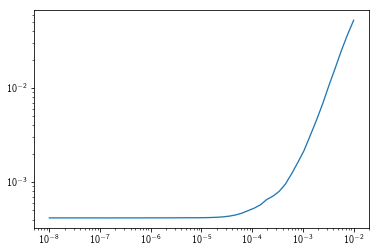

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.2648552168552957e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
451 / 30000 iterations
applying cutoff
... took 50.383610735996626 seconds
(g,i)=(20000,0) ...
find hyperparameter
current scores [0.00021918 0.00021918 0.00021918 0.00021918 0.00021917 0.00021918
 0.00021918 0.00021919 0.00021921 0.00021924 0.00021928 0.00021935
 0.00021944 0.00021956 0.0002197  0.00021983 0.00021998 0.00022022
 0.00022055 0.00022094 0.00022138 0.00022195 0.00022235 0.00022237
 0.00022272 0.00022332 0.00022461 0.00022698 0.00023153 0.00023943
 0.00025197 0.00027228 0.00030182 0.00033803 0.0003825  0.00046645
 0.00053237 0.00062281 0.00078346 0.00106801 0.00144912 0.00201311
 0.00300668 0.00449691 0.0068

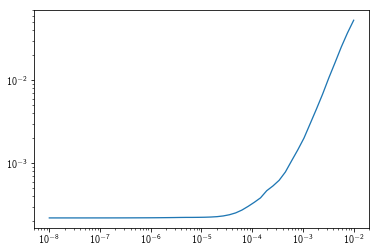

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.0888435964774783e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
439 / 30000 iterations
applying cutoff
... took 49.75031687505543 seconds
(g,i)=(20000,1) ...
find hyperparameter
current scores [0.00022939 0.00022939 0.00022938 0.00022938 0.00022938 0.00022938
 0.00022939 0.00022939 0.00022939 0.00022939 0.0002294  0.00022944
 0.00022954 0.00022961 0.00022975 0.00022995 0.00023023 0.00023062
 0.00023094 0.0002312  0.00023141 0.00023152 0.00023163 0.0002317
 0.00023212 0.00023264 0.00023383 0.00023627 0.00024069 0.00024789
 0.00025914 0.00027848 0.00030735 0.00034707 0.00039067 0.00047153
 0.00053663 0.00062637 0.00078442 0.00106262 0.00144455 0.00200181
 0.00298087 0.00442199 0.006722

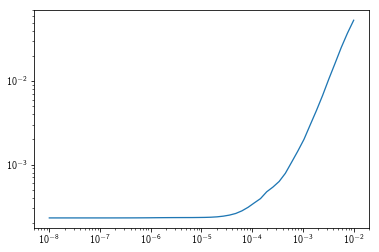

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.329951810515372e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
432 / 30000 iterations
applying cutoff
... took 49.396558542968705 seconds
(g,i)=(20000,2) ...
find hyperparameter
current scores [0.00021266 0.00021266 0.00021266 0.00021266 0.00021267 0.00021267
 0.00021267 0.00021267 0.00021266 0.00021265 0.00021262 0.00021258
 0.00021255 0.00021249 0.00021245 0.00021242 0.00021238 0.00021234
 0.0002123  0.00021227 0.00021241 0.00021259 0.00021287 0.00021315
 0.00021386 0.00021503 0.00021658 0.00021908 0.00022325 0.00023066
 0.00024238 0.00026205 0.00029251 0.0003269  0.00037062 0.00045313
 0.00051206 0.00060215 0.00076115 0.00104126 0.00142348 0.00198237
 0.0029648  0.0044007  0.00670

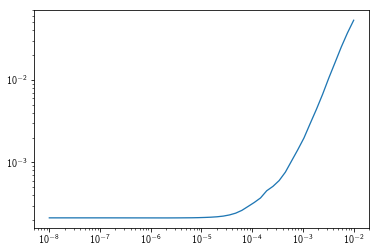

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.1209508879201924e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
404 / 30000 iterations
applying cutoff
... took 47.40765237400774 seconds
(g,i)=(20000,3) ...
find hyperparameter
current scores [0.00022201 0.00022201 0.00022201 0.00022199 0.00022201 0.00022201
 0.00022202 0.00022204 0.00022206 0.00022206 0.00022205 0.00022205
 0.00022206 0.00022206 0.00022206 0.00022207 0.00022201 0.00022192
 0.00022181 0.00022167 0.00022151 0.00022155 0.00022167 0.00022191
 0.00022243 0.00022324 0.00022489 0.00022753 0.00023171 0.00023872
 0.00025067 0.00027085 0.00029957 0.0003388  0.00038437 0.00046686
 0.00052951 0.00062828 0.00080217 0.00110254 0.00150816 0.00211114
 0.00316871 0.00474066 0.00721

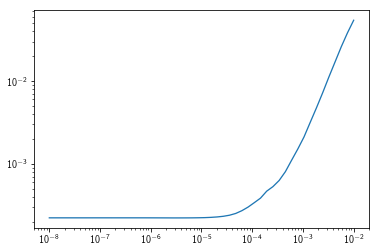

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
412 / 30000 iterations
applying cutoff
... took 47.248754978063516 seconds
(g,i)=(20000,4) ...
find hyperparameter
current scores [0.00022753 0.00022752 0.00022752 0.00022752 0.00022752 0.00022753
 0.00022753 0.00022753 0.00022753 0.00022753 0.00022755 0.0002276
 0.00022767 0.00022772 0.0002278  0.00022787 0.00022791 0.00022803
 0.00022814 0.00022821 0.00022834 0.0002285  0.00022882 0.00022941
 0.00023031 0.00023118 0.00023269 0.00023519 0.00023905 0.00024566
 0.00025695 0.00027666 0.00030447 0.00033434 0.00037968 0.00045334
 0.00050298 0.00059065 0.00074533 0.00101796 0.00139567 0.00194365
 0.00290786 0.00433489 0.006607

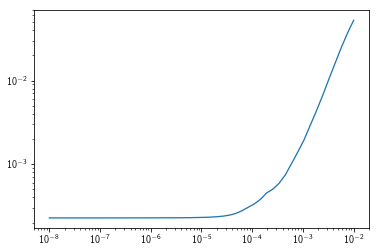

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.0888435964774783e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
440 / 30000 iterations
applying cutoff
... took 50.49641923501622 seconds
(g,i)=(20000,5) ...
find hyperparameter
current scores [0.00021132 0.00021132 0.00021133 0.00021133 0.00021133 0.00021134
 0.00021136 0.00021138 0.00021142 0.00021147 0.00021154 0.00021161
 0.00021166 0.00021173 0.00021177 0.00021183 0.00021195 0.00021217
 0.00021246 0.00021289 0.00021329 0.00021359 0.00021383 0.00021409
 0.00021449 0.00021524 0.00021662 0.00021897 0.00022316 0.00023036
 0.00024161 0.00026064 0.00029154 0.00032483 0.00036826 0.00044914
 0.00050345 0.00059054 0.00074395 0.00101401 0.00139423 0.00193535
 0.00288658 0.00431685 0.00654

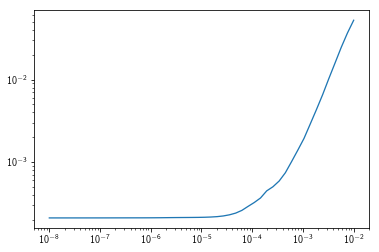

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.3257113655901082e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
447 / 30000 iterations
applying cutoff
... took 51.20955041702837 seconds
(g,i)=(20000,6) ...
find hyperparameter
current scores [0.00022308 0.00022308 0.00022308 0.00022308 0.00022308 0.00022308
 0.00022308 0.00022308 0.00022309 0.0002231  0.0002231  0.00022311
 0.0002231  0.00022311 0.00022315 0.00022322 0.00022329 0.00022348
 0.00022367 0.0002238  0.0002239  0.00022406 0.00022439 0.00022471
 0.00022502 0.00022594 0.00022771 0.00023025 0.00023474 0.00024241
 0.00025432 0.00027111 0.00029811 0.00033369 0.00037776 0.00045814
 0.00051952 0.00060829 0.00076515 0.00104194 0.00142471 0.00197743
 0.0029498  0.00438901 0.00667

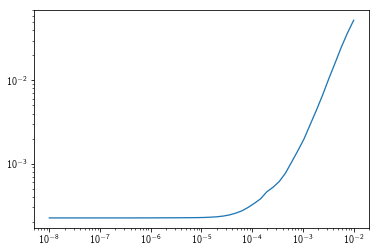

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=1.3257113655901082e-08, lambda=1.0)!
status 0: Optimization terminated successfully.
458 / 30000 iterations
applying cutoff
... took 55.614211178035475 seconds
(g,i)=(20000,7) ...
find hyperparameter
current scores [0.00024505 0.00024505 0.00024505 0.00024504 0.00024504 0.00024503
 0.00024502 0.00024503 0.00024504 0.00024502 0.00024501 0.000245
 0.000245   0.00024499 0.00024498 0.00024498 0.00024502 0.0002451
 0.00024527 0.00024559 0.00024617 0.00024676 0.00024749 0.00024788
 0.00024827 0.00024918 0.00025024 0.00025236 0.00025642 0.000263
 0.00027426 0.00029375 0.00032245 0.00036051 0.00040371 0.00048484
 0.00056905 0.00065597 0.00080971 0.00108109 0.00145891 0.002003
 0.00296065 0.00435705 0.00661786 0.

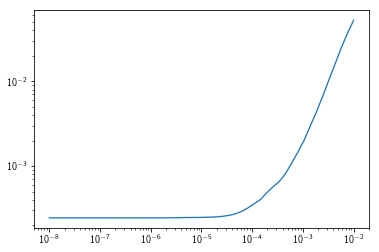

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=6.866488450042998e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
439 / 30000 iterations
applying cutoff
... took 52.42096586700063 seconds
(g,i)=(20000,8) ...
find hyperparameter
current scores [0.00022091 0.00022089 0.00022088 0.00022088 0.00022084 0.00022083
 0.00022083 0.0002208  0.00022077 0.00022073 0.00022066 0.00022056
 0.00022045 0.0002203  0.00022013 0.00022003 0.00021993 0.00021983
 0.00021967 0.00021954 0.00021954 0.00021967 0.00021998 0.00022037
 0.00022117 0.00022232 0.00022423 0.00022754 0.00023273 0.00024079
 0.0002537  0.00027496 0.00030461 0.00034264 0.00038885 0.00046591
 0.00052141 0.00061306 0.00077576 0.00106376 0.00145013 0.00202244
 0.00303016 0.00452412 0.006889

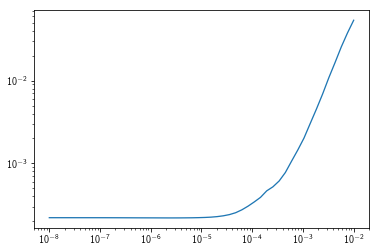

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=2.811768697974231e-06, lambda=1.0)!
status 0: Optimization terminated successfully.
416 / 30000 iterations
applying cutoff
... took 47.674572797026485 seconds
(g,i)=(20000,9) ...
find hyperparameter
current scores [0.00023278 0.00023276 0.00023275 0.00023274 0.00023272 0.0002327
 0.00023268 0.00023265 0.00023261 0.00023257 0.00023253 0.00023249
 0.00023247 0.00023247 0.0002325  0.00023259 0.00023274 0.00023298
 0.00023332 0.00023362 0.00023388 0.0002343  0.00023465 0.00023502
 0.00023542 0.00023641 0.00023788 0.00024041 0.00024498 0.00025198
 0.00026337 0.00028339 0.00031212 0.00034648 0.00039182 0.00047569
 0.00053949 0.00062777 0.00078411 0.00106049 0.0014313  0.00198204
 0.00295153 0.00439343 0.006676

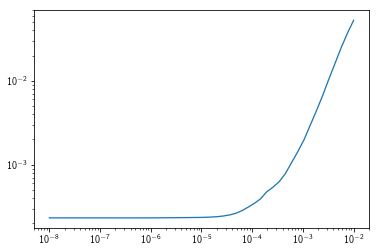

estimating model
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=3.906939937054621e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
435 / 30000 iterations
applying cutoff
... took 50.25384233798832 seconds


In [26]:
estimated_rates = dict()
l1_err = dict()
used_alphas = dict()
for g in gillespie_realisations:
    cv_res_g = cv_results[cv_results.gillespie_realisations == g]
    estimated_rates[g] = dict() 
    l1_err[g] = dict()
    used_alphas[g] = dict()
    for i in iids:
        print("(g,i)=({},{}) ...".format(g, i))
        
        print("find hyperparameter")
        cv_res = cv_res_g[cv_res_g.iid == i]
        cv_res = cv_res.sort_values(by="alpha")
        current_alphas = np.array([x for x in cv_res.alpha.values])
        
        current_scores = np.array([x for x in cv_res.scores.values])[:,:] # use all folds
        current_scores = np.mean(current_scores, axis=1) # average over folds
        #print(current_alphas)
        print("current scores", -current_scores)
        min_indices = np.argmin(-current_scores, axis=0)
        optimal_alpha = alphas[min_indices]
        used_alphas[g][i] = optimal_alpha
        plt.plot(current_alphas, -current_scores)
        plt.xscale("log")
        plt.yscale("log")
        plt.show()
        t1 = time.perf_counter()
        
        print("estimating model")
        rates, analyse = rs.estimate(alpha=optimal_alpha, gillespie_realisations=g, 
                                     iid_id=i, traj_file_path="./gillespie_trajs_init_1_shuffled.h5")
        
        print("applying cutoff")
        # @TODO do or do not apply cutoff?
        rates[rates < 0.22] = 0.
        
        estimated_rates[g][i] = rates
        l1_err[g][i] = np.sum(np.abs(rates-desired_rates))
        t2 = time.perf_counter()
        print("... took {} seconds".format(t2-t1))

In [27]:
rates_arr = np.array([ [estimated_rates[g][i] for i in iids] for g in gillespie_realisations])
l1_err_arr = np.array([ [l1_err[g][i] for i in iids] for g in gillespie_realisations])
used_alphas_arr = np.array([ [used_alphas[g][i] for i in iids] for g in gillespie_realisations])

In [28]:
if True:
    np.savez("case2_validation_alphas_and_solutions_averagefolds_shuffled.npz", rates=rates_arr, l1_dev=l1_err_arr, alpha_val=used_alphas_arr)

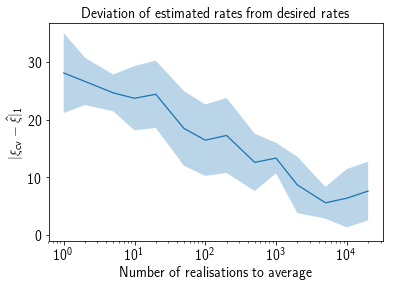

In [29]:
plt.style.use("lm")
mean = np.mean(l1_err_arr, axis=1)
err = np.std(l1_err_arr, axis=1) #/ np.sqrt(10.) # 10 iids
plt.plot(gillespie_realisations, mean)
plt.fill_between(gillespie_realisations, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
plt.xscale("log")
plt.xlabel("Number of realisations to average")
plt.ylabel(r"$|\xi_\mathrm{cv}-\hat{\xi}|_1$")
plt.title("Deviation of estimated rates from desired rates")
ymin, ymax = plt.ylim()
plt.ylim(-1,ymax)
plt.savefig("case2_convergence_averagefolds_shuffled.pdf", bbox_inches="tight", transparent=True)

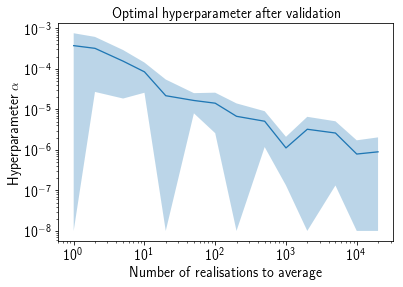

In [30]:

mean = np.mean(used_alphas_arr, axis=1)
err = np.std(used_alphas_arr, axis=1) #/ np.sqrt(10.) # 10 iids
plt.plot(gillespie_realisations, mean)
plt.fill_between(gillespie_realisations, y1=np.clip(mean-err, 1e-8, 1.), y2=mean+err, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of realisations to average")
plt.ylabel(r"Hyperparameter $\alpha$")
plt.title("Optimal hyperparameter after validation")
#ymin, ymax = plt.ylim()
#plt.ylim(-1,ymax)
plt.savefig("case2_best_hyperparameter_averagefolds_shuffled.pdf", bbox_inches="tight", transparent=True)

In [ ]:
g_idx = 13
i_idx = 3
print(gillespie_realisations[g_idx])
analysis.plot_rates_bar(desired_rates, np.mean(rates_arr[g_idx], axis=0))

#plt.savefig("case2_exemplary_solution_n"+str(gillespie_realisations[g_idx])+".pdf", bbox_inches="tight", transparent=True)

# LSQ solution

In [31]:
estimated_rates = dict()
l1_err = dict()
used_alphas = dict()
for g in gillespie_realisations:
    cv_res_g = cv_results[cv_results.gillespie_realisations == g]
    estimated_rates[g] = dict() 
    l1_err[g] = dict()
    used_alphas[g] = dict()
    for i in iids:
        print("(g,i)=({},{}) ...".format(g, i))
        
        optimal_alpha = 0.
        used_alphas[g][i] = optimal_alpha

        t1 = time.perf_counter()
        
        print("estimating model with alpha={}".format(optimal_alpha))
        rates, analyse = rs.estimate(alpha=optimal_alpha, gillespie_realisations=g, iid_id=i, 
                                     traj_file_path="./gillespie_trajs_init_1_shuffled.h5")
        
        print("applying cutoff")
        rates[rates < 0.22] = 0.
        
        estimated_rates[g][i] = rates
        l1_err[g][i] = np.sum(np.abs(rates-desired_rates))
        t2 = time.perf_counter()
        print("... took {} seconds".format(t2-t1))

(g,i)=(1,0) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
239 / 30000 iterations
applying cutoff
... took 27.81295348308049 seconds
(g,i)=(1,1) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
264 / 30000 iterations
applying cutoff
... took 32.36881070304662 seconds
(g,i)=(1,2) ...
estimating model with alpha=0.0
obtaining regulation network with dt

0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
276 / 30000 iterations
applying cutoff
... took 31.872886970057152 seconds
(g,i)=(2,9) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
272 / 30000 iterations
applying cutoff
... took 31.030593400006182 seconds
(g,i)=(5,0) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alp

0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
340 / 30000 iterations
applying cutoff
... took 38.816218808991835 seconds
(g,i)=(10,7) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
325 / 30000 iterations
applying cutoff
... took 39.971162412082776 seconds
(g,i)=(10,8) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (a

0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
383 / 30000 iterations
applying cutoff
... took 42.70378421701025 seconds
(g,i)=(50,5) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
381 / 30000 iterations
applying cutoff
... took 42.130230098962784 seconds
(g,i)=(50,6) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (al

0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
404 / 30000 iterations
applying cutoff
... took 44.509467616910115 seconds
(g,i)=(200,3) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
385 / 30000 iterations
applying cutoff
... took 42.61277583404444 seconds
(g,i)=(200,4) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (

0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
420 / 30000 iterations
applying cutoff
... took 47.63269096403383 seconds
(g,i)=(1000,1) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
401 / 30000 iterations
applying cutoff
... took 44.21741451800335 seconds
(g,i)=(1000,2) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully 

0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
429 / 30000 iterations
applying cutoff
... took 47.24627972196322 seconds
(g,i)=(2000,9) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
421 / 30000 iterations
applying cutoff
... took 47.048679437022656 seconds
(g,i)=(5000,0) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully

0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
450 / 30000 iterations
applying cutoff
... took 52.11707305593882 seconds
(g,i)=(10000,7) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
459 / 30000 iterations
applying cutoff
... took 51.794151337002404 seconds
(g,i)=(10000,8) ...
estimating model with alpha=0.0
obtaining regulation network with dt = 0.003
scaling population up, timestep down and bimol. rates down by factor 500.0
generating data using gillespie kmc averaged over 1 realisations
0.003
0.003
Trying tolerance 1e-16
optimization problem did exit successful

In [32]:
rates_arr = np.array([ [estimated_rates[g][i] for i in iids] for g in gillespie_realisations])
l1_err_arr = np.array([ [l1_err[g][i] for i in iids] for g in gillespie_realisations])
used_alphas_arr = np.array([ [used_alphas[g][i] for i in iids] for g in gillespie_realisations])

In [33]:
if True:
    np.savez("case2_solutions_lsq_zippedtraj_shuffled.npz", rates=rates_arr, l1_dev=l1_err_arr, alpha_val=used_alphas_arr, gillespie_realisations=gillespie_realisations, desired_rates=desired_rates)

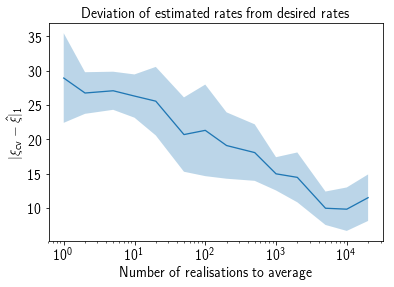

In [34]:
#plt.style.use("lm")
mean = np.mean(l1_err_arr, axis=1)
err = np.std(l1_err_arr, axis=1) #/ np.sqrt(10.) # 10 iids
plt.plot(gillespie_realisations, mean)
plt.fill_between(gillespie_realisations, y1=np.clip(mean-err, 0., 1e16), y2=mean+err, alpha=0.3)
plt.xscale("log")
plt.xlabel("Number of realisations to average")
plt.ylabel(r"$|\xi_\mathrm{cv}-\hat{\xi}|_1$")
plt.title("Deviation of estimated rates from desired rates")
ymin, ymax = plt.ylim()
#plt.ylim(-1,ymax)
plt.savefig("case2_convergence_lsq_zippedtraj_shuffled.pdf", bbox_inches="tight", transparent=True)